# This code is for the model inversion with SEEG or EEG (HMC algorihtm)

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import subprocess
import pandas as pd
import os.path as op

sys.path.append('/root/capsule/code/vep/core')
sys.path.append('/root/capsule/code/vep/stan')
import vep_prepare_op
import vep_mcmc
import analyze_fit
import stan

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compute data features

In [4]:
# define parameters
pid = 'Patient1'
basicfilename = 'P1_TI_SEEG_fit'
mcmc_fit_id = 'fit_mcmc_nf_v1'


# parameters to compute the 50 estimations, using stan optimize
n_optimize = 50 # number of optimization
n_optimize_jobs = 50 # number of optimization jobs to be run in parallel

# parameters to select the best estimations to create R files containing initial values for MCMC chains
n_best = 8

# parameters for MCMC
n_chains_per_init = 2 # number of chains to run for each set of initial values
n_sample_jobs = 16 # number of chains jobs to be run in parallel

In [5]:
data_sim_folder = f'/data/dataSim/{pid}'
#subj_raw_dir  = f'{data_sim_folder}/func/'
results_dir = f'/results/sampling/{pid}'
os.makedirs(f'{results_dir}', exist_ok=True)
#basicfilename = f'{pid}_seizure_run01_seeg'



In [6]:
vhdrname = f'{data_sim_folder}/{basicfilename}.npz'

In [7]:
hpf = 10
lpf = 1
vep_fit_id = None
onset = None
offset = None
ts_on = None
ts_on_cut = None
ts_off_cut = None
bad_contacts = None

datafeatures_fname = vep_mcmc.datafeatures__rpne_039__fname(vhdr_fname=basicfilename,
                                                   mcmc_fit_id=mcmc_fit_id,
                                                   subj_proc_dir=results_dir,
                                                   hpf=hpf, lpf=lpf)

In [8]:
datafeatures_fname

'/results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/P1_TI_SEEG_fit_hpf10_lpf1__datafeatures.R'

In [9]:
data_sim = np.load(vhdrname)
gain = data_sim['gain']
tts  = data_sim['time_steps']
seeg = data_sim['seeg']
SC   = data_sim['SC']
#gain_prior = data_sim['gain_prior']


In [10]:
sfreq = 250.

seeg_4feature = -(seeg[:,100:700] - seeg[:,100:700].mean(axis=0)) + np.random.normal(0, 0.2, size=len(seeg[:,100:700].T))
seeg_4feature = np.concatenate([np.random.normal(0, 0.2, size=[len(seeg), 300]), seeg_4feature,np.random.normal(0, 0.2, size=[len(seeg), 200])],axis = 1) 

data = vep_prepare_op.prepare_data_feature_op(SC, seeg_4feature.T,gain, sfreq, hpf, lpf)

In [11]:
n_samples = 150
data_features = data['slp']
ds_freq = int(data_features.shape[0]/n_samples)
data_features__resampled = data_features[0:-1:ds_freq] - np.min(data_features)

In [12]:
maxima_highlighted = {'n': 10, 'ch_names': data_sim['ch_names'], 'fontsize': 'large',
                      'legend_location': 'upper left'}
onset_offset = [onset, offset]

title = op.basename(basicfilename)
vhdr_fname_prefix = f'{pid}_ses-01_task-seizure_acq-'
if op.basename(basicfilename).startswith(vhdr_fname_prefix):
    title = f'{pid}, {title[len(vhdr_fname_prefix):]}'
title = title.rstrip('_ieeg.vhdr')
title += f': data features, hpf={hpf} Hz, lpf={lpf} Hz'


In [13]:
data_features__resampled_t = np.arange(np.shape(data_features__resampled)[0])

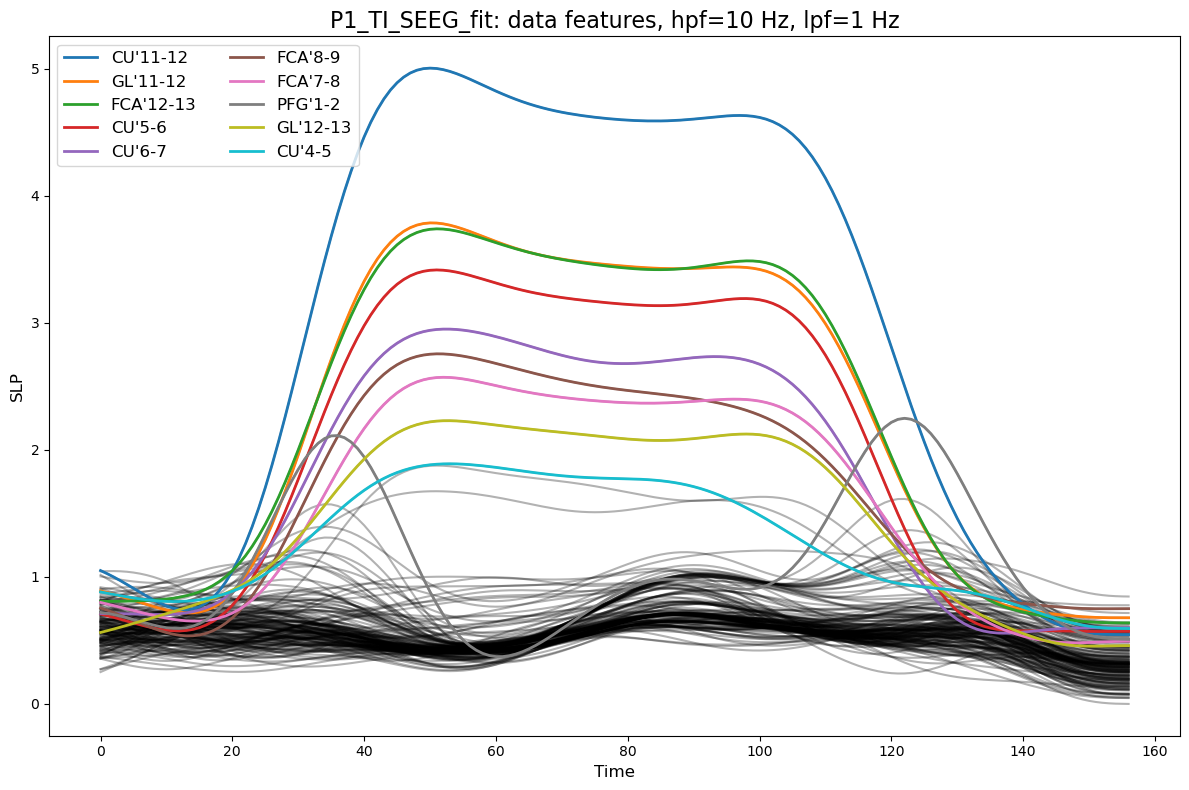

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
vep_prepare_op.plot_data_features_ax(data_features__resampled, data_features__resampled_t, ax, title=title, maxima_highlighted=maxima_highlighted)
fig.tight_layout()

>> Save /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/figures/P1_TI_SEEG_fit_hpf10_lpf1__datafeatures.png
>> Save /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/figures/P1_TI_SEEG_fit_hpf10_lpf1__log_datafeatures.png


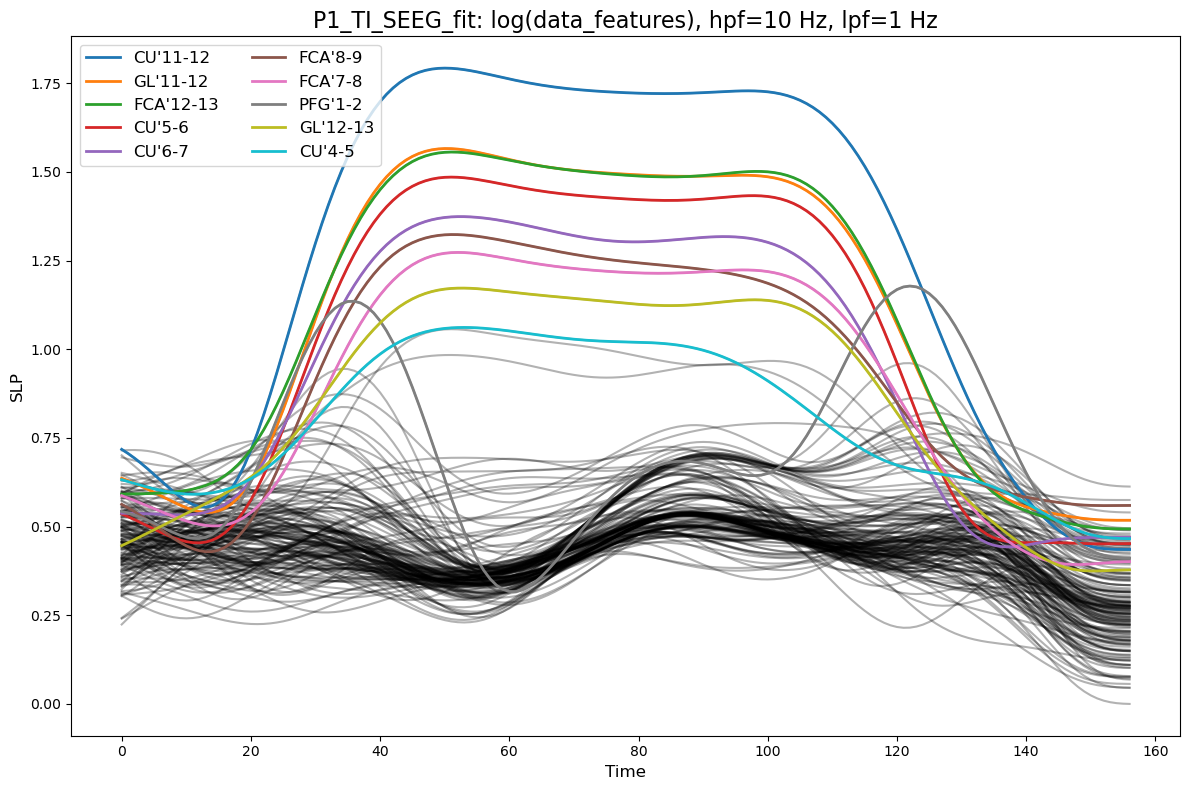

In [15]:
data_features__resampled = data_features__resampled - np.min(data_features__resampled)+1


output_dir = op.dirname(datafeatures_fname)
fig_dir = op.join(output_dir, 'figures')
os.makedirs(fig_dir, exist_ok=True)
fname = op.join(fig_dir, op.basename(datafeatures_fname).replace('.R', '.png'))
print(f'>> Save {fname}')
fig.savefig(fname)
# for log, data_features have to be strictly positive
if not np.all(data_features__resampled > 0):
    err_msg = ['>>>> Error: data features can not have negative values (log) <<<<']
    raise Exception(err_msg)

# log(data_features)
title = title.replace('data features', 'log(data_features)')
fig, ax = plt.subplots(figsize=(12, 8))
vep_prepare_op.plot_data_features_ax(np.log(data_features__resampled), data_features__resampled_t,
                                  ax, title=title, maxima_highlighted=maxima_highlighted)
fig.tight_layout()

fname = fname.replace('datafeatures', 'log_datafeatures')
print(f'>> Save {fname}')
fig.savefig(fname)

In [16]:
# Save the HMC data files
ts_off = None
vhdr_fname = basicfilename
# compute eig
U, s, Vh = np.linalg.svd(gain)
eig = Vh.T

# create r data file
data_rpne_039 = {}
data_rpne_039['ns'], data_rpne_039['nn'] = gain.shape
data_rpne_039['nt']   = data_features__resampled_t.size
data_rpne_039['Obs']  = data_features__resampled
data_rpne_039['SC']   = SC
data_rpne_039['gain'] = gain
data_rpne_039['eig']  = eig

# write r data file
print(f'>> Save {datafeatures_fname}')
stan.rdump(datafeatures_fname, data_rpne_039)

# save parameters
dfp_fname = op.join(op.dirname(datafeatures_fname), 'data_feature_parameters_mcmc.txt')
print(f'>> Save {dfp_fname}')
vep_prepare_op.save_data_feature_parameters_(dfp_fname, vhdr_fname, onset, offset, scaleplt=None,
                                          hpf=hpf, lpf=lpf, ts_on=ts_on, ts_off=ts_off,
                                          ts_cut=ts_on_cut, ts_off_cut=ts_off_cut,
                                          th_prior_W=None, th_prior_M=None, act_chs=None,
                                          replace_onset=None, replace_offset=None, replace_scale=None,
                                          bad_contacts=bad_contacts, remove_roi=None)



>> Save /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/P1_TI_SEEG_fit_hpf10_lpf1__datafeatures.R
>> Save /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/data_feature_parameters_mcmc.txt
>> Save current data_feature__parameters to /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/vep_dfs/data_feature_parameters_mcmc.txt
	vhdr_fname: P1_TI_SEEG_fit
	seizure onset: None
	seizure offset: None
	bad_contacts: None
	remove_roi: None
	scaleplt: None
	hpf: 10
	lpf: 1
	ts_on: None
	ts_off: None
	ts_cut: None
	th_prior_W: None
	th_prior_M: None
	replace_onset: None
	replace_offset: None
	replace_scale: None


## MCMC estimation

### Compute initial values
This steps computes 50 estimations, using stan optimize.\
The 8 best estimations are then selected, based on their likelihood.\
These 8 estimations are used to create initial values for MCMC chains.

In [17]:
stanmodel = 'vep_mcmc'

In [18]:
parallel_jobs_fname = vep_mcmc.create__jobs__optimize__rpne_039(datafeatures_fname=datafeatures_fname,
                                                                stanmodel = stanmodel,
                                                                init_uniform_distribution_range=5,
                                                                n_optimize=n_optimize, n_jobs=n_optimize_jobs, 
                                                                tol_param=1e-10)

>> Save 50 jobs in /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/optimize_vep_mcmc/P1_TI_SEEG_fit_hpf10_lpf1/jobs/do_all_local.bash
>> Run: time /usr/bin/parallel -j 50 < /results/sampling/Patient1/mcmc/fit_mcmc_nf_v1/optimize_vep_mcmc/P1_TI_SEEG_fit_hpf10_lpf1/jobs/do_all_local.bash


## The output of the HMC is approximately 32 GB, Therefore, we have commented out this cell here.
## We have also shared the original Stan code so that you can easily build it on your own machine.

In [19]:

#vep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_optimize_jobs)

In [25]:
# read csv files and get the 'lp__'
'''
datafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')
output_dir = op.join(op.dirname(op.dirname(datafeatures_fname)),f'optimize_{stanmodel}', datafeatures_id)
logs_dir = op.join(output_dir, 'logs')
csv_dir = op.join(output_dir, 'csv')

lp = np.full(n_optimize, np.nan)
j_ok, j_nok, j_exc = 0, 0, 0

for j in range(n_optimize):
    job_id = f'{datafeatures_id}__j{j}'
    log_fname = op.join(logs_dir, f'{job_id}.log')
    print(f'Reading status from {log_fname}... ', end='', flush=True)
    try:
        status = analyze_fit.analyze_log_file(log_fname)
    except Exception as e:
        print(e)
        j_exc += 1
        continue
    print(status)
    if status == 'ok':
        j_ok += 1
        csv_fname = op.join(csv_dir, f'{job_id}.csv')
        assert op.exists(csv_fname)
        print(f'\t\t>> Reading lp__ from {csv_fname}...', end=' ', flush=True)
        samples = stan.read_samples([csv_fname], variables_of_interest=['lp__'])
        print('ok')
        lp[j] = samples['lp__'][0]
    else:
        j_nok += 1

assert j_ok + j_nok + j_exc == n_optimize
print()
print(f'>> Jobs: {n_optimize}, ok: {j_ok}, nok: {j_nok}, exc: {j_exc}')

sorted_indicies = np.argsort(-lp)
n_best_indices = sorted_indicies[:n_best]

print()
print(f'>> Keeping jobs {n_best_indices} with lp__ {lp[n_best_indices]}')
print()
'''

"\ndatafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')\noutput_dir = op.join(op.dirname(op.dirname(datafeatures_fname)),f'optimize_{stanmodel}', datafeatures_id)\nlogs_dir = op.join(output_dir, 'logs')\ncsv_dir = op.join(output_dir, 'csv')\n\nlp = np.full(n_optimize, np.nan)\nj_ok, j_nok, j_exc = 0, 0, 0\n\nfor j in range(n_optimize):\n    job_id = f'{datafeatures_id}__j{j}'\n    log_fname = op.join(logs_dir, f'{job_id}.log')\n    print(f'Reading status from {log_fname}... ', end='', flush=True)\n    try:\n        status = analyze_fit.analyze_log_file(log_fname)\n    except Exception as e:\n        print(e)\n        j_exc += 1\n        continue\n    print(status)\n    if status == 'ok':\n        j_ok += 1\n        csv_fname = op.join(csv_dir, f'{job_id}.csv')\n        assert op.exists(csv_fname)\n        print(f'\t\t>> Reading lp__ from {csv_fname}...', end=' ', flush=True)\n        samples = stan.read_samples([csv_fname], variables_of_interest=['lp__'])\n     

In [26]:
roi = vep_prepare_op.read_vep_mrtrix_lut()
# select the 8 best estimations and create R files containing initial values
'''
vep_mcmc.create__init_files__sample__rpne_039(datafeatures_fname,
                                              stanmodel=stanmodel,
                                              n_optimize=n_optimize, n_best=n_best)
'''

'\nvep_mcmc.create__init_files__sample__rpne_039(datafeatures_fname,\n                                              stanmodel=stanmodel,\n                                              n_optimize=n_optimize, n_best=n_best)\n'

## Run MCMC chains

In [23]:
# create jobs to run MCMC
'''
parallel_jobs_fname = vep_mcmc.create__jobs__sample__rpne_039(datafeatures_fname,
                                                              stanmodel = stanmodel,
                                                              n_init=n_best, 
                                                              n_chains_per_init=n_chains_per_init,
                                                              n_jobs=n_sample_jobs)

vep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_sample_jobs)
'''

'\nparallel_jobs_fname = vep_mcmc.create__jobs__sample__rpne_039(datafeatures_fname,\n                                                              stanmodel = stanmodel,\n                                                              n_init=n_best, \n                                                              n_chains_per_init=n_chains_per_init,\n                                                              n_jobs=n_sample_jobs)\n\nvep_mcmc.run_jobs_parallel(parallel_jobs_fname=parallel_jobs_fname, n_jobs=n_sample_jobs)\n'

## Plot MCMC diagnostics

## We've keep the plot here so that you can see what the results looks that. The size of result files to big to generate here.


Reading sub-01_seizure_run01_s_hpf10_lpf1__j0_diagnostic.csv... 
	divergence: 0.0/500 (0.00 %) of divergent samples => OK
	accept_stat: mean across samples is 0.99 => OK
>> Saving /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/sub-01_seizure_run01_s_hpf10_lpf1__j0_diagnostic.png...

Reading sub-01_seizure_run01_s_hpf10_lpf1__j1_diagnostic.csv... 
	divergence: 0.0/500 (0.00 %) of divergent samples => OK
	accept_stat: mean across samples is 0.99 => OK
>> Saving /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/sub-01_seizure_run01_s_hpf10_lpf1__j1_diagnostic.png...

Reading sub-01_seizure_run01_s_hpf10_lpf1__j2_diagnostic.csv... 
	divergence: 0.0/500 (0.00 %) of divergent samples => OK
	accept_stat: mean across samples is 0.99 => OK
>> Saving /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/

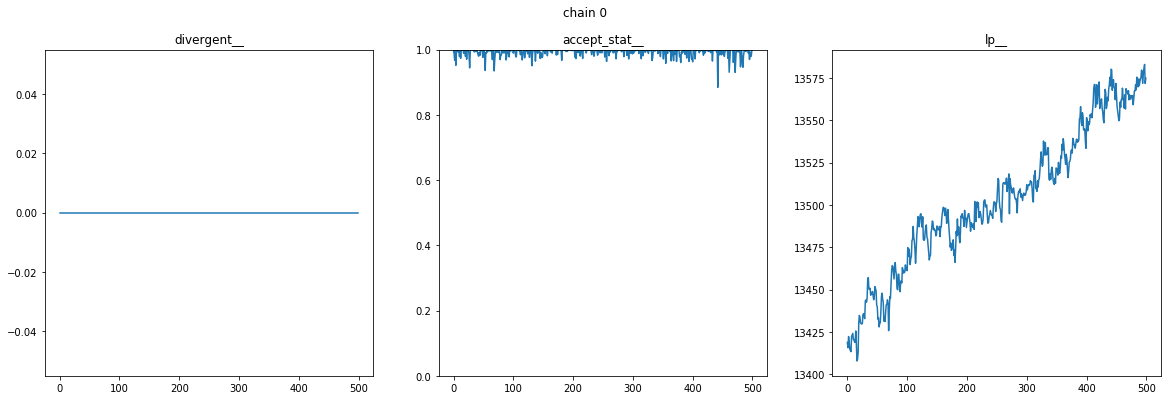

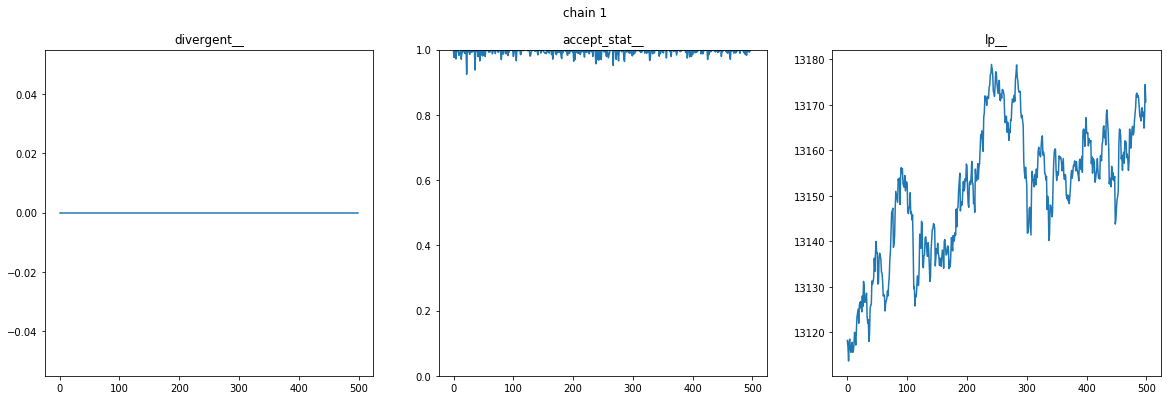

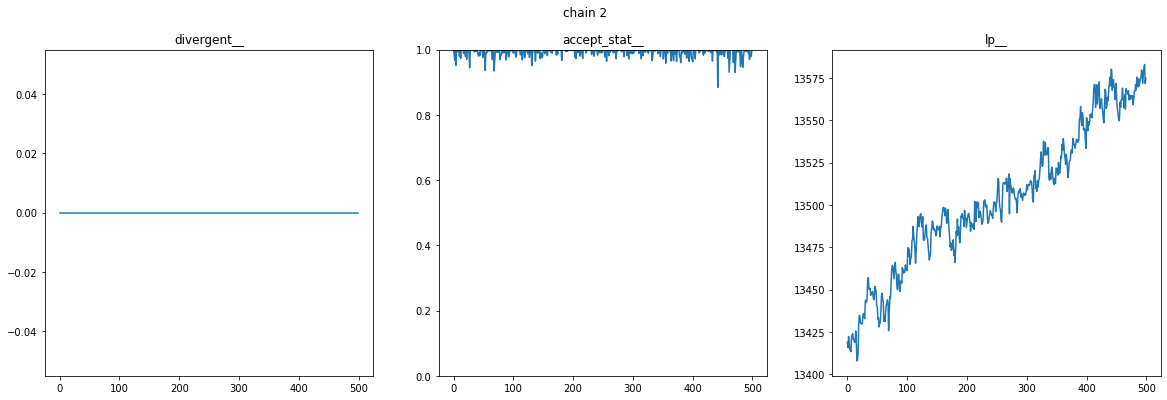

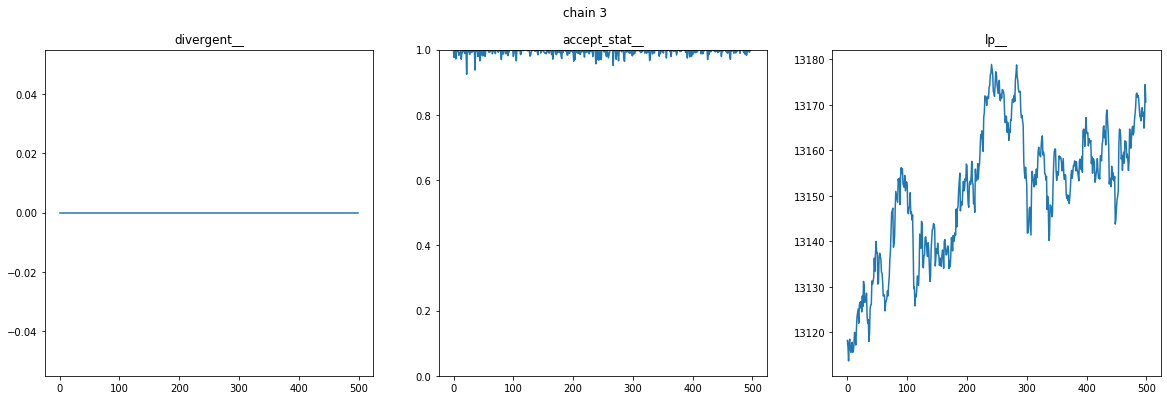

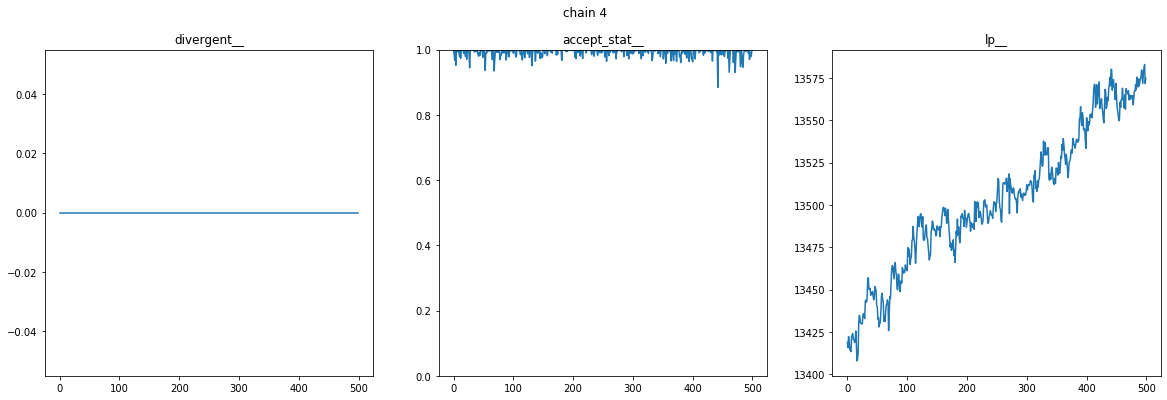

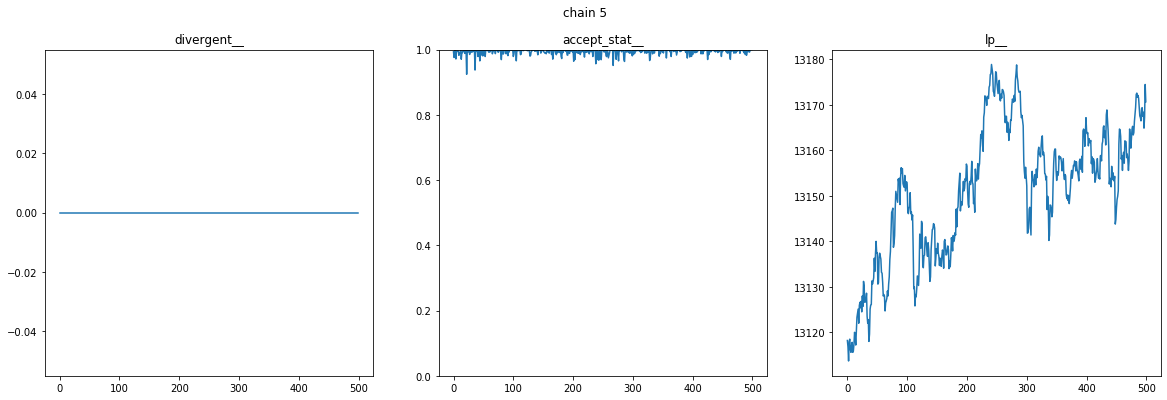

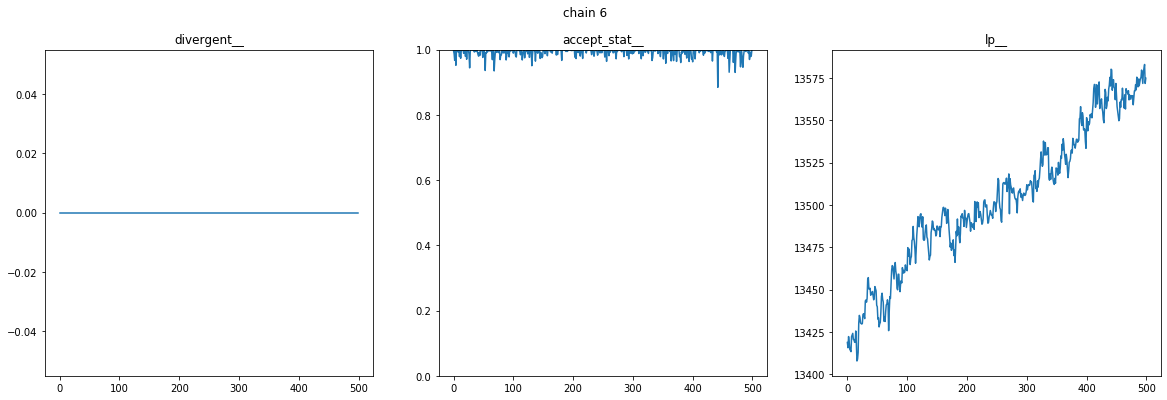

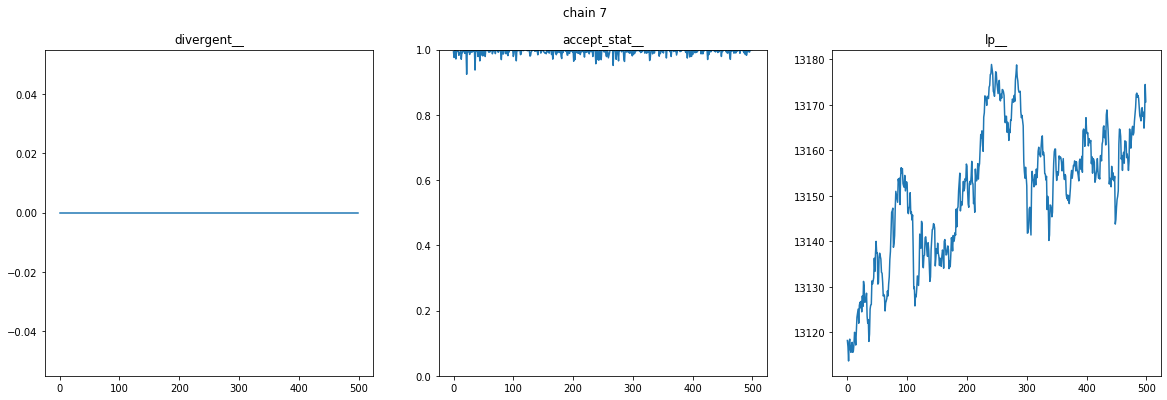

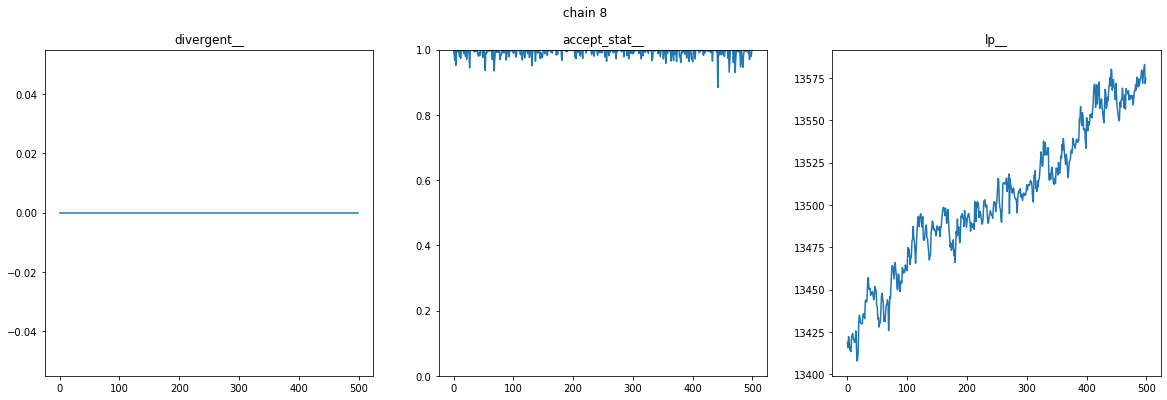

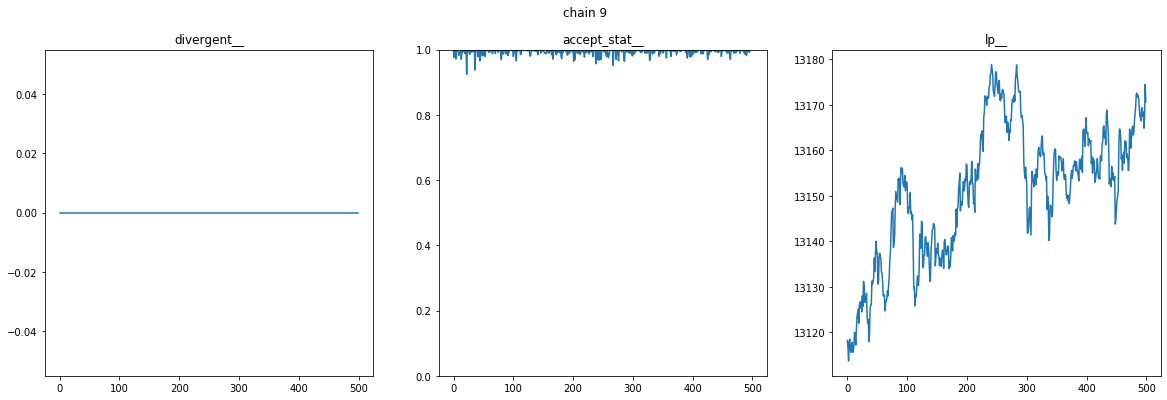

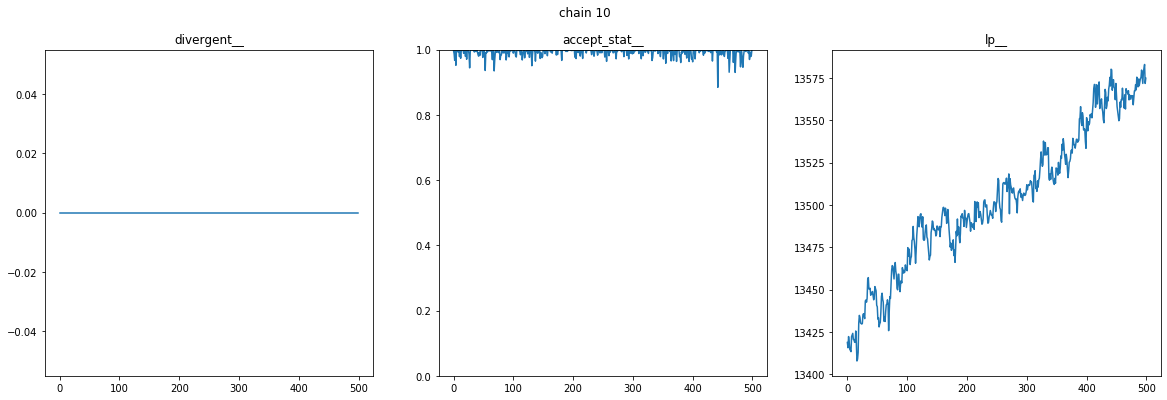

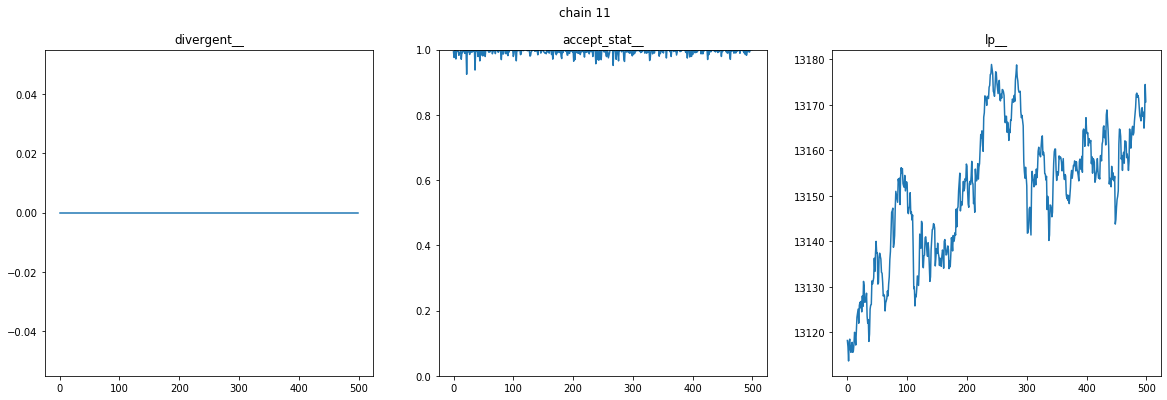

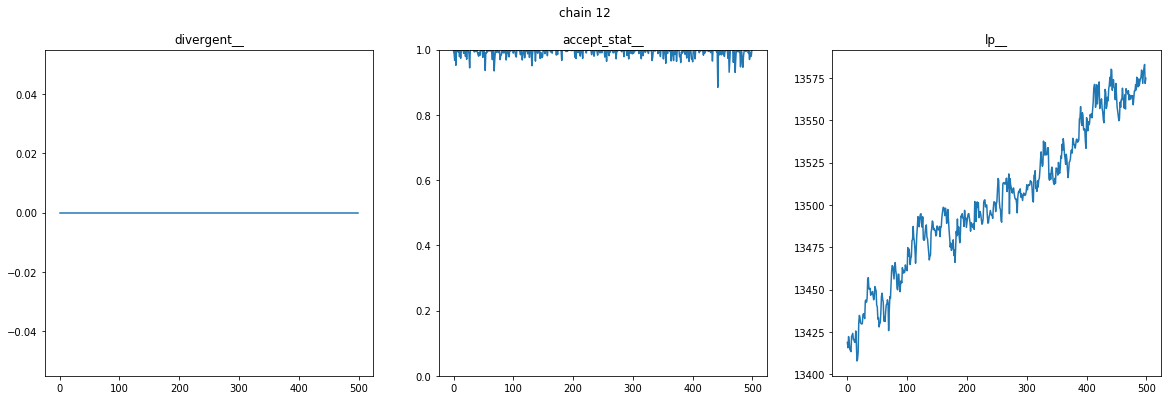

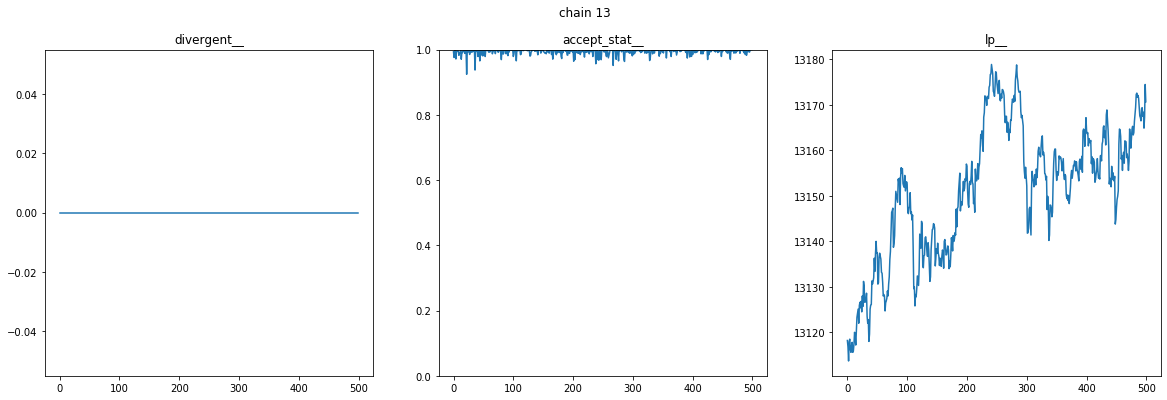

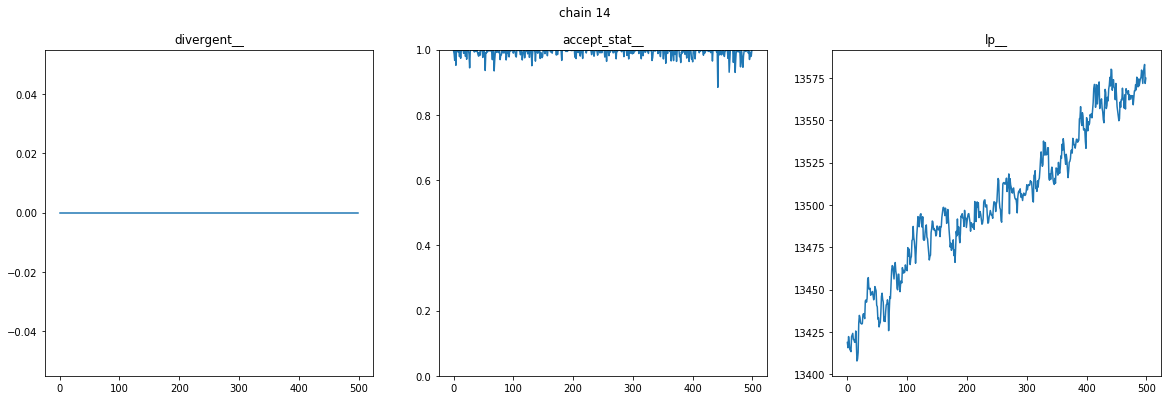

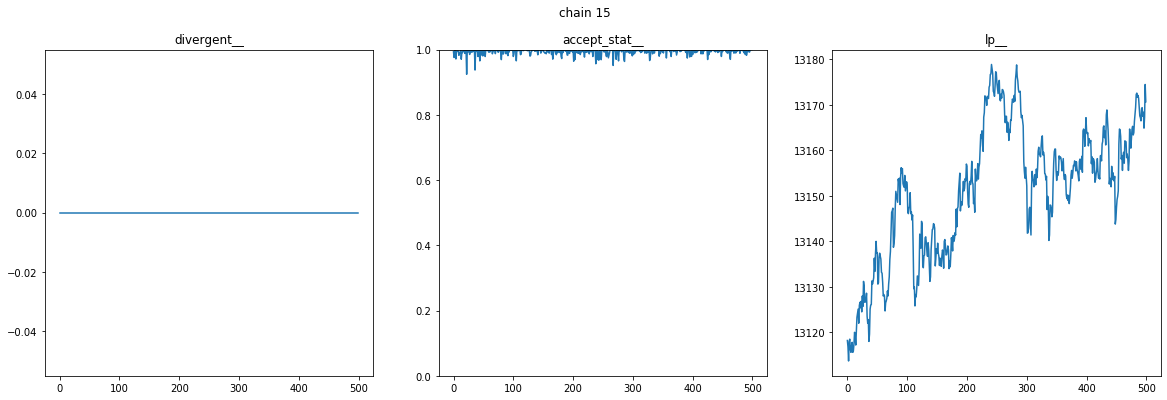

In [58]:
#chains_status = vep_mcmc.chains_diagnostic(datafeatures_fname,stanmodel=stanmodel)
#print(chains_status)
# We've keep the plot here so that you can see what the results looks that

In [63]:
# write variables of interest to the disk to speed up future usage
# loglikelihood for each chain with status == True to compute their probabilities
'''
chains_indices = np.nonzero(chains_status)[0]
samples = vep_mcmc.extract_samples__variables_of_interest__parfor(datafeatures_fname, 
                                                                  chains_indices,
                                                                  stanmodel=stanmodel,
                                                                  variables_of_interest__csv=['log_lik'],
                                                                  variables_of_interest__npz=['log_lik', 'x0', 'xhat_q', 'x'])
'''

In [64]:
# write the R code to compute the probability of each chain
# input files are csv files containing loglikelihhood
'''
csv__log_lik__fnames = []
datafeatures_id = op.basename(datafeatures_fname).rstrip('__datafeatures.R')
sample_output_dir = op.join(op.dirname(op.dirname(datafeatures_fname)), f'sample_{stanmodel}', datafeatures_id)
csv_dir = op.join(sample_output_dir, 'csv')
k = 'log_lik'
for c in chains_indices:
    job_id = f'{datafeatures_id}__j{c}'
    csv_fname = op.join(csv_dir, f'{job_id}.csv')
    v_fname = csv_fname.replace('.csv', f'__{k}.csv')
    assert op.exists(v_fname)
    csv__log_lik__fnames.append(v_fname)
    
print(csv__log_lik__fnames)
'''

['/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j0__log_lik.csv', '/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j1__log_lik.csv', '/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j2__log_lik.csv', '/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j3__log_lik.csv', '/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j4__log_lik.csv', '/data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/sub-01_seizure_run01_s_hpf10_lpf1__j5__log_lik.csv', '/data/ve

# Plot MCMC results, i.e. posterior distributions of x0

Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_0.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_0.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_1.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_1.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_2.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_2.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_04

/home/prior/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_10.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_10.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_11.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_11.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part1_chan_12.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_rpne_040/sub-01_seizure_run01_s_hpf10_lpf1/csv/figures/posterior_x0_part2_chan_12.png
Save /data/vep_study/vep_open/sub-01/func/mcmc/fit_mcmc_nf_v1/sample_r

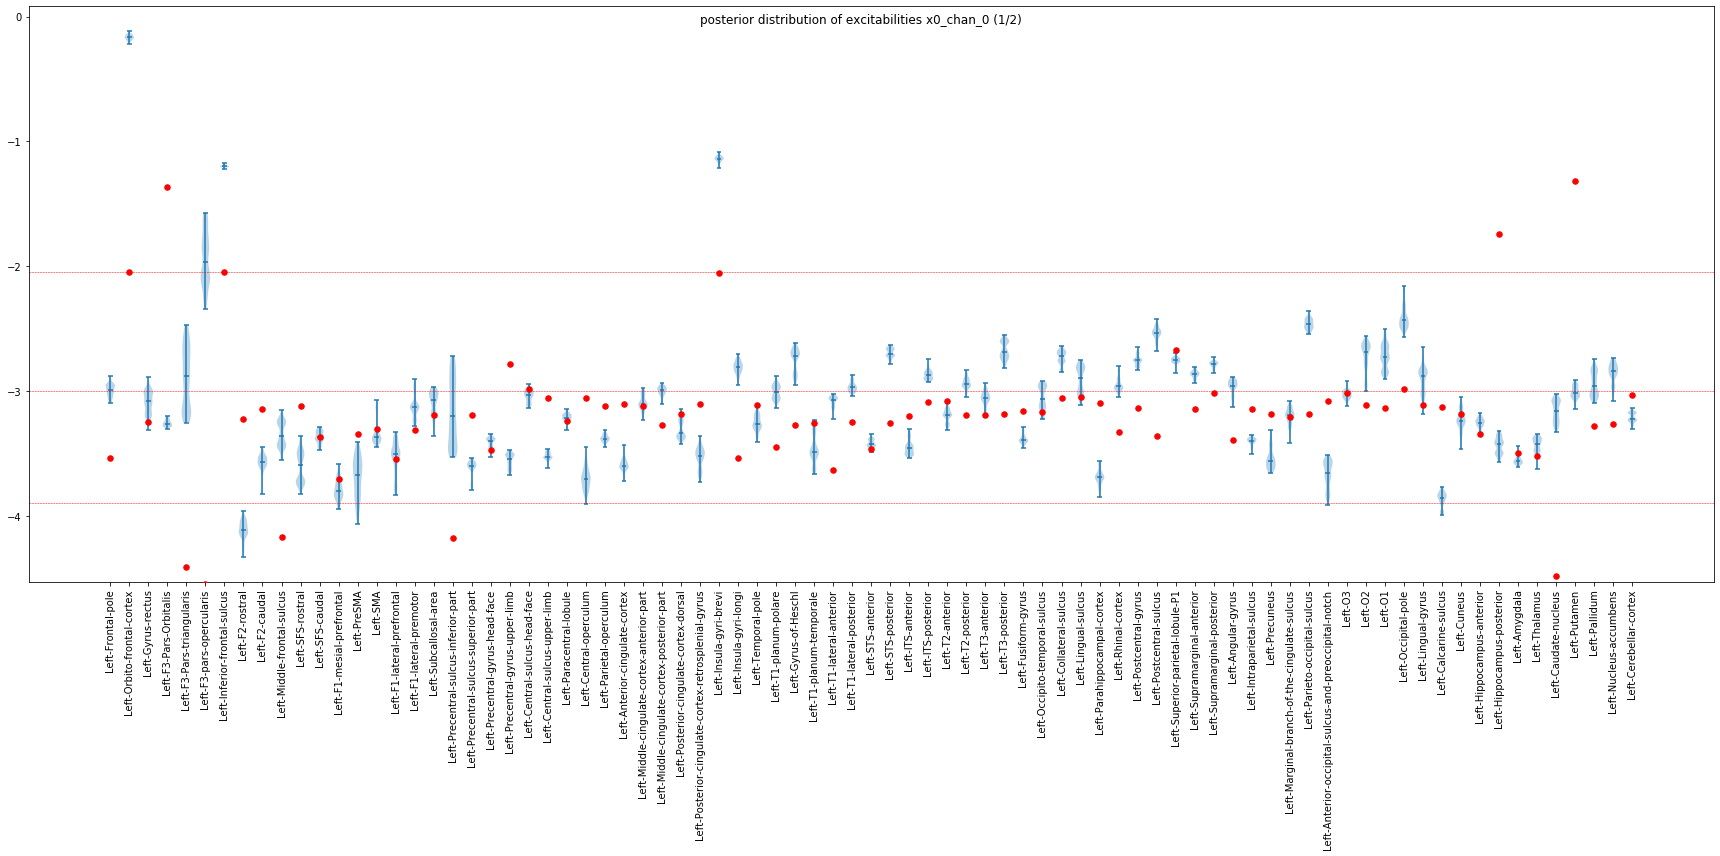

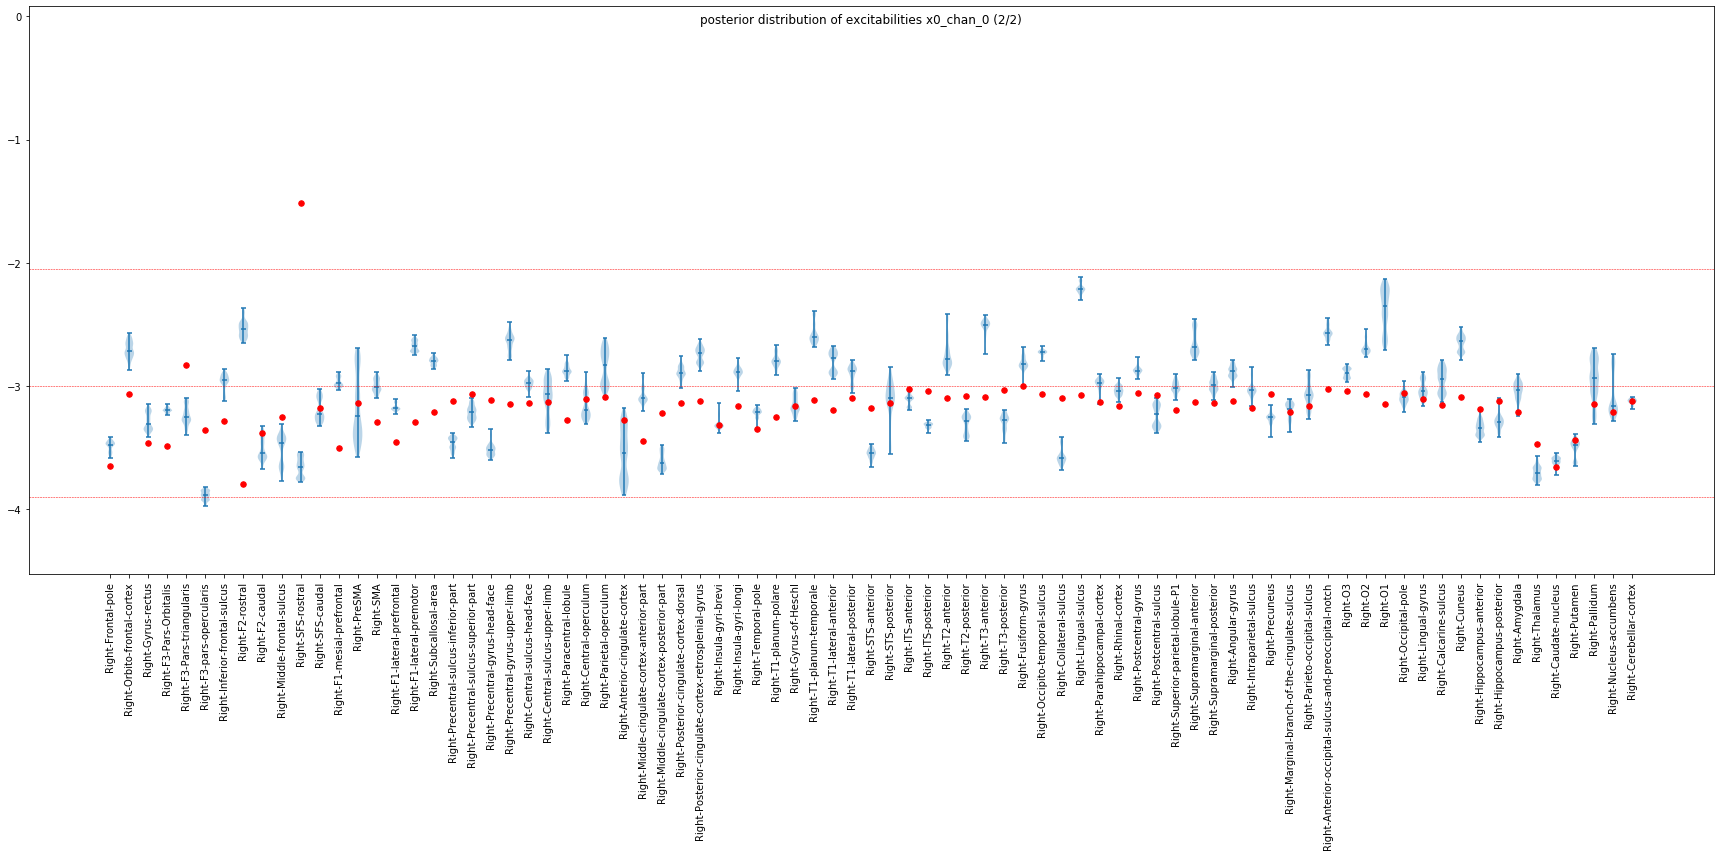

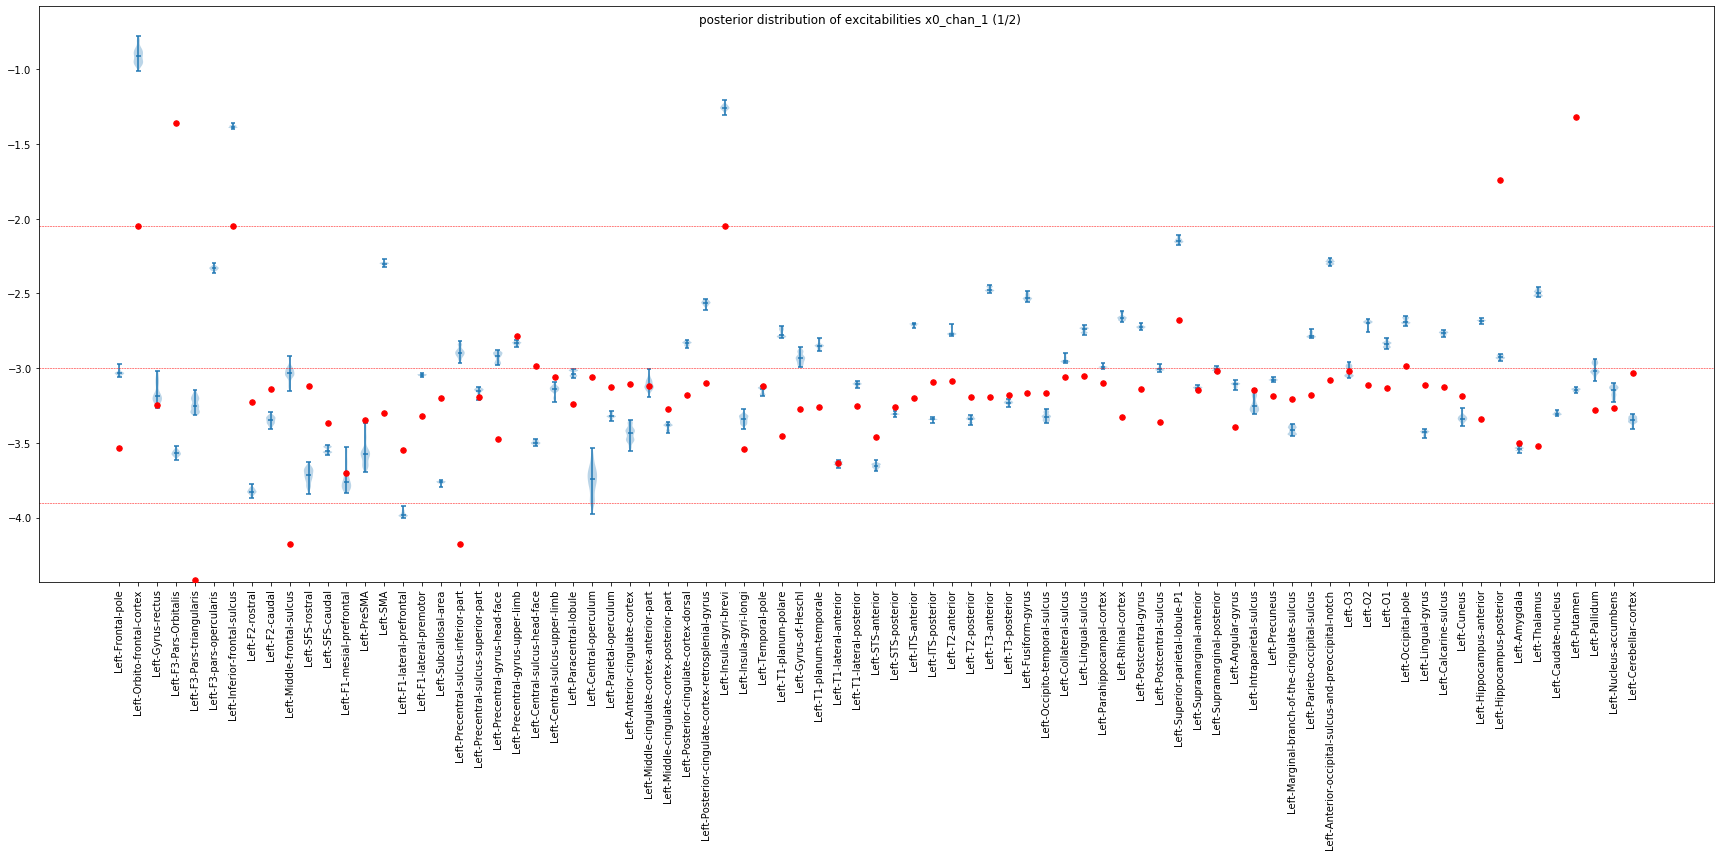

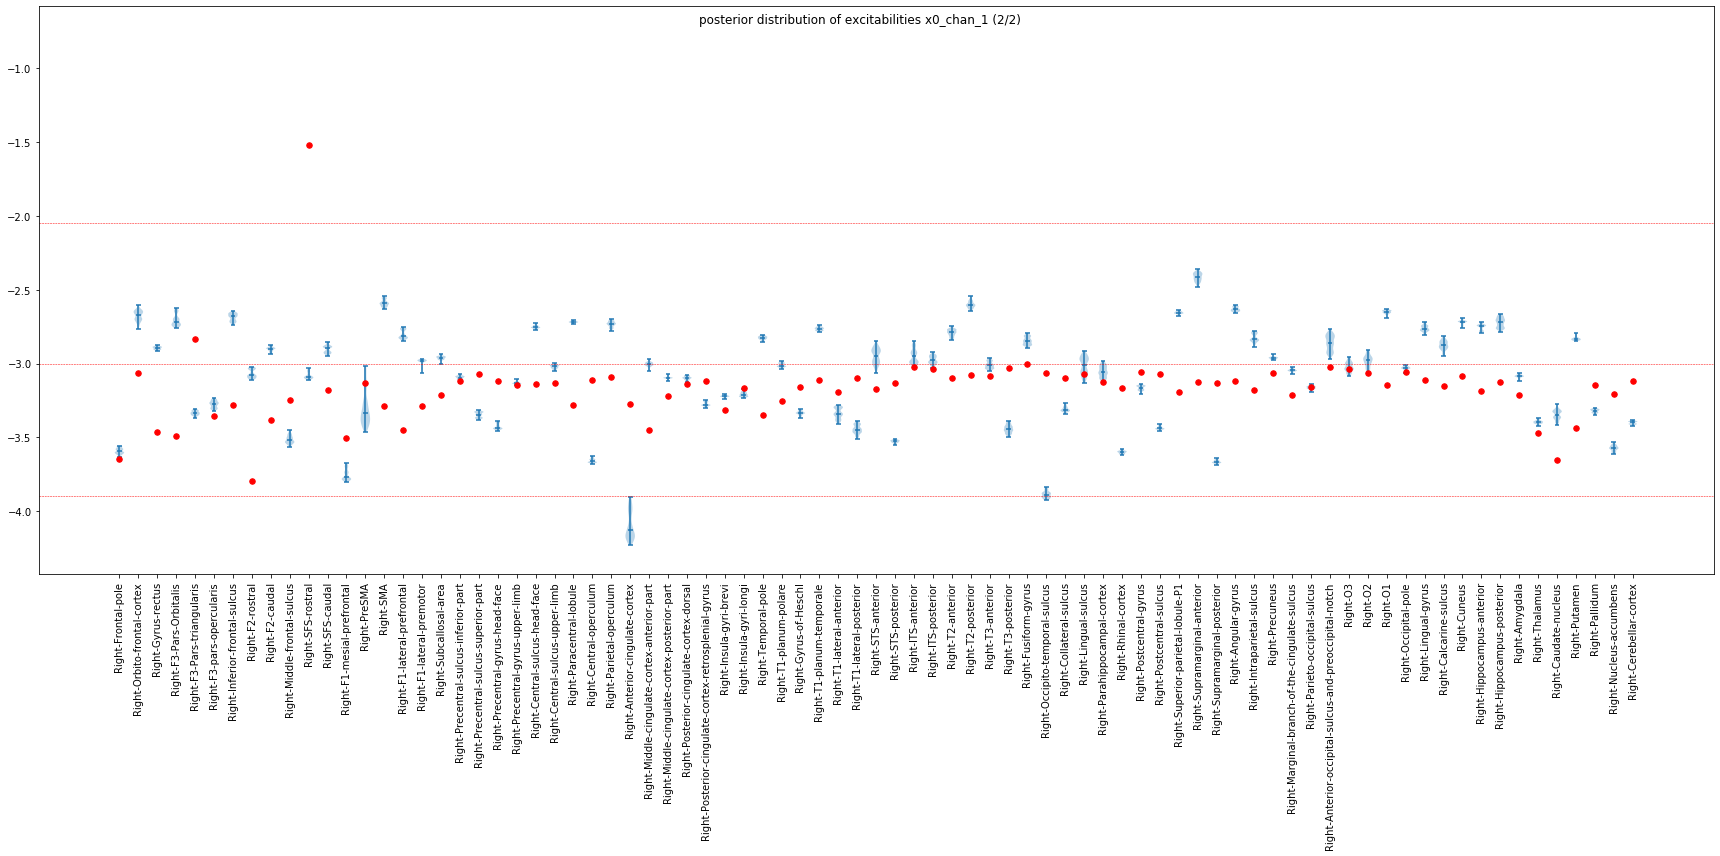

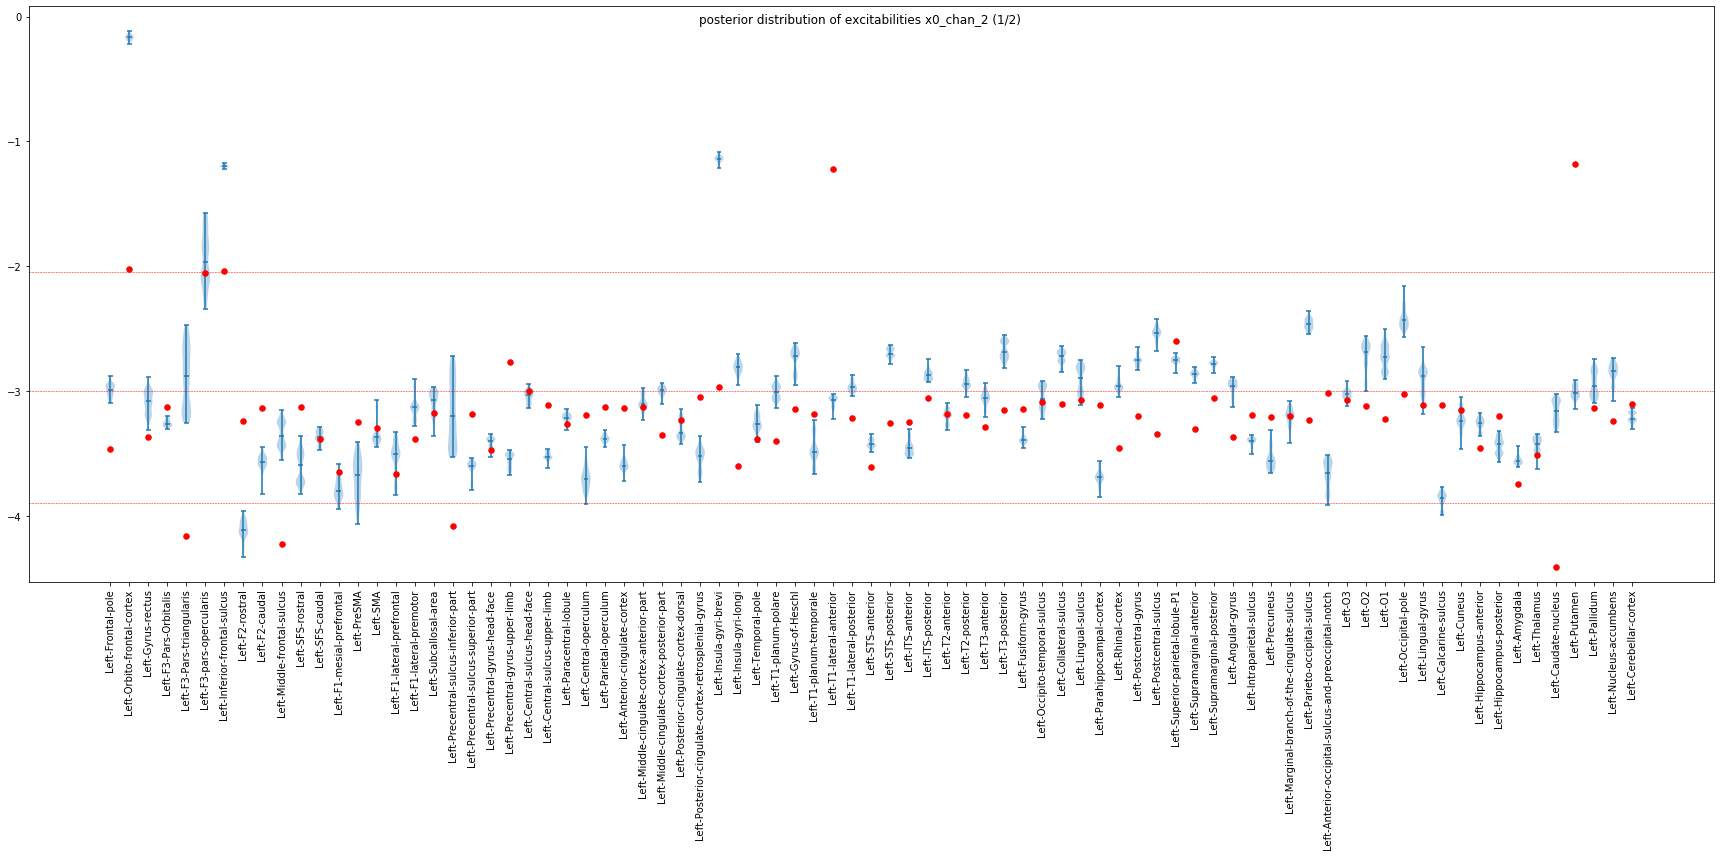

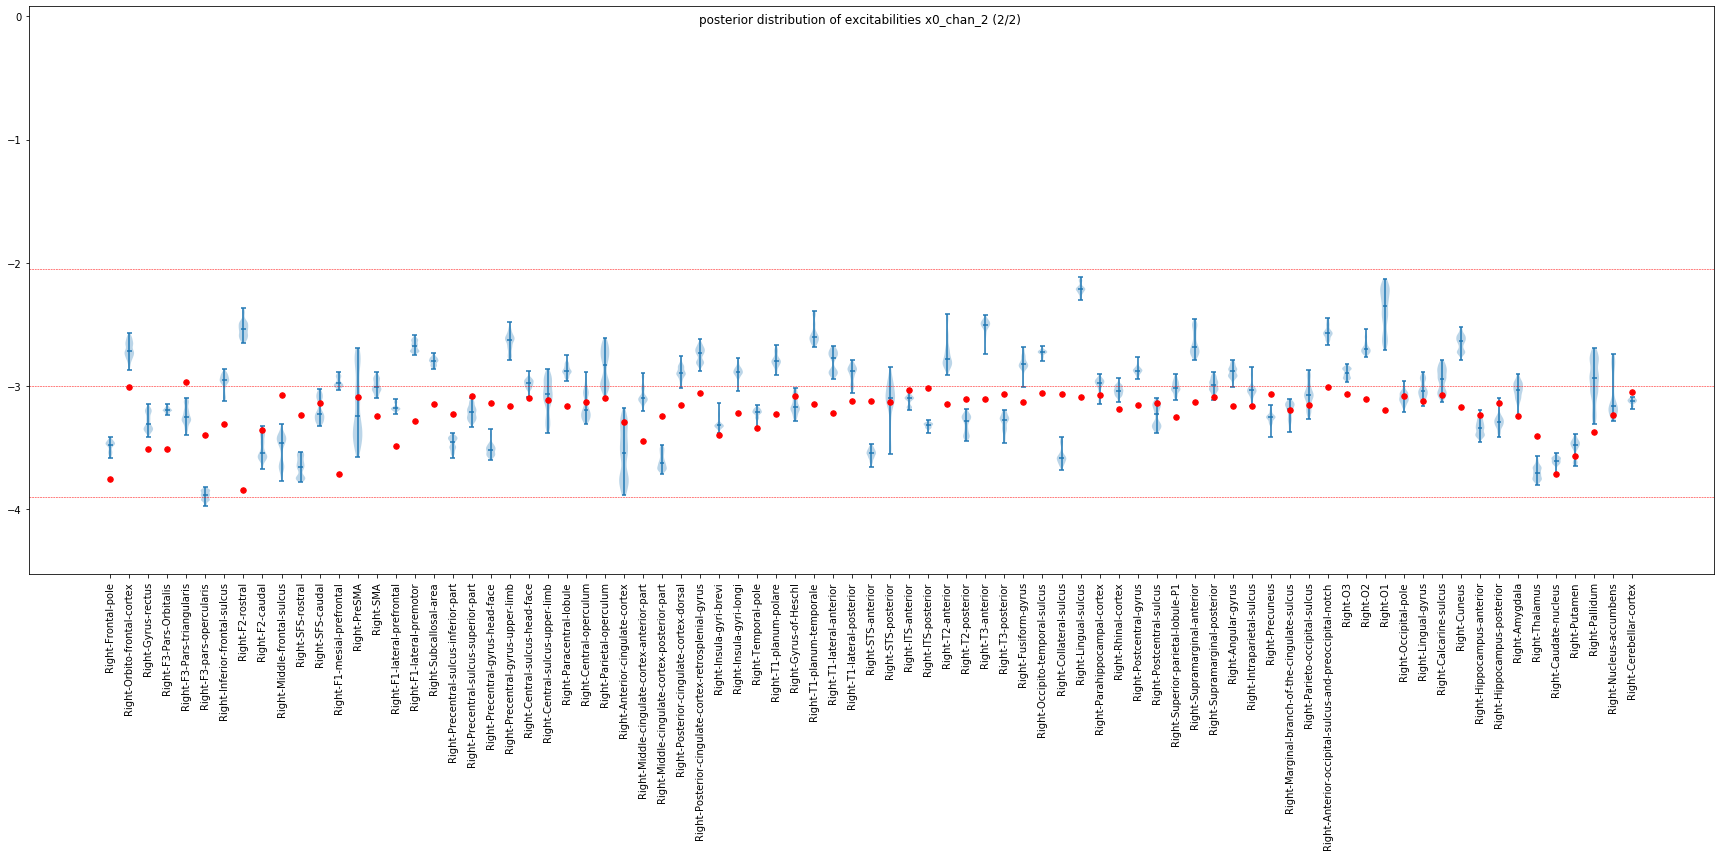

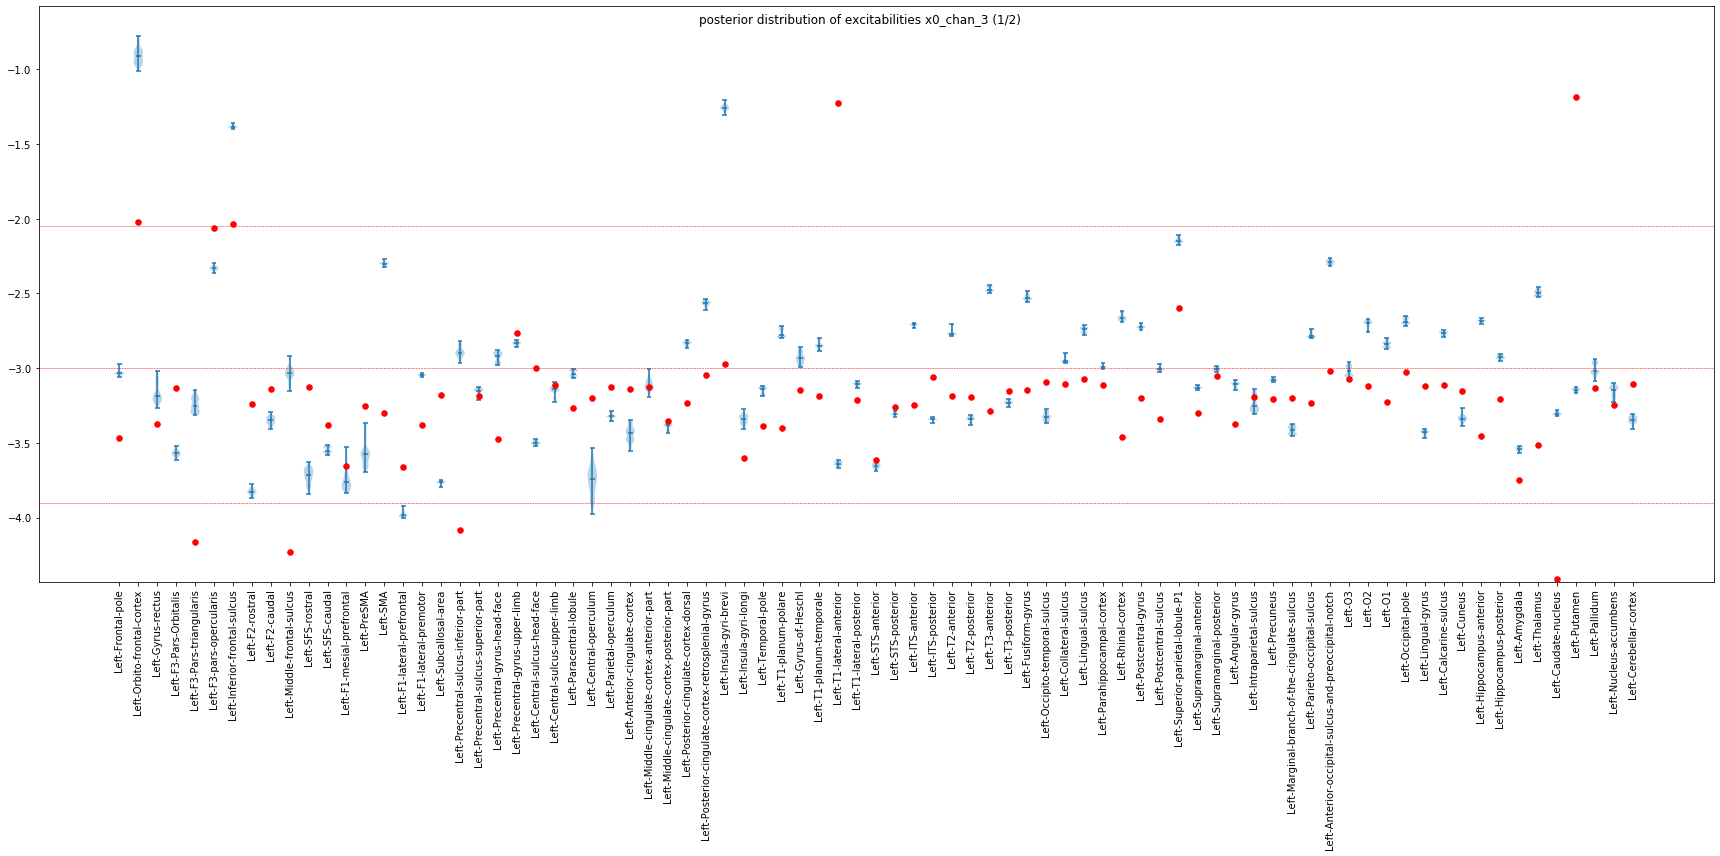

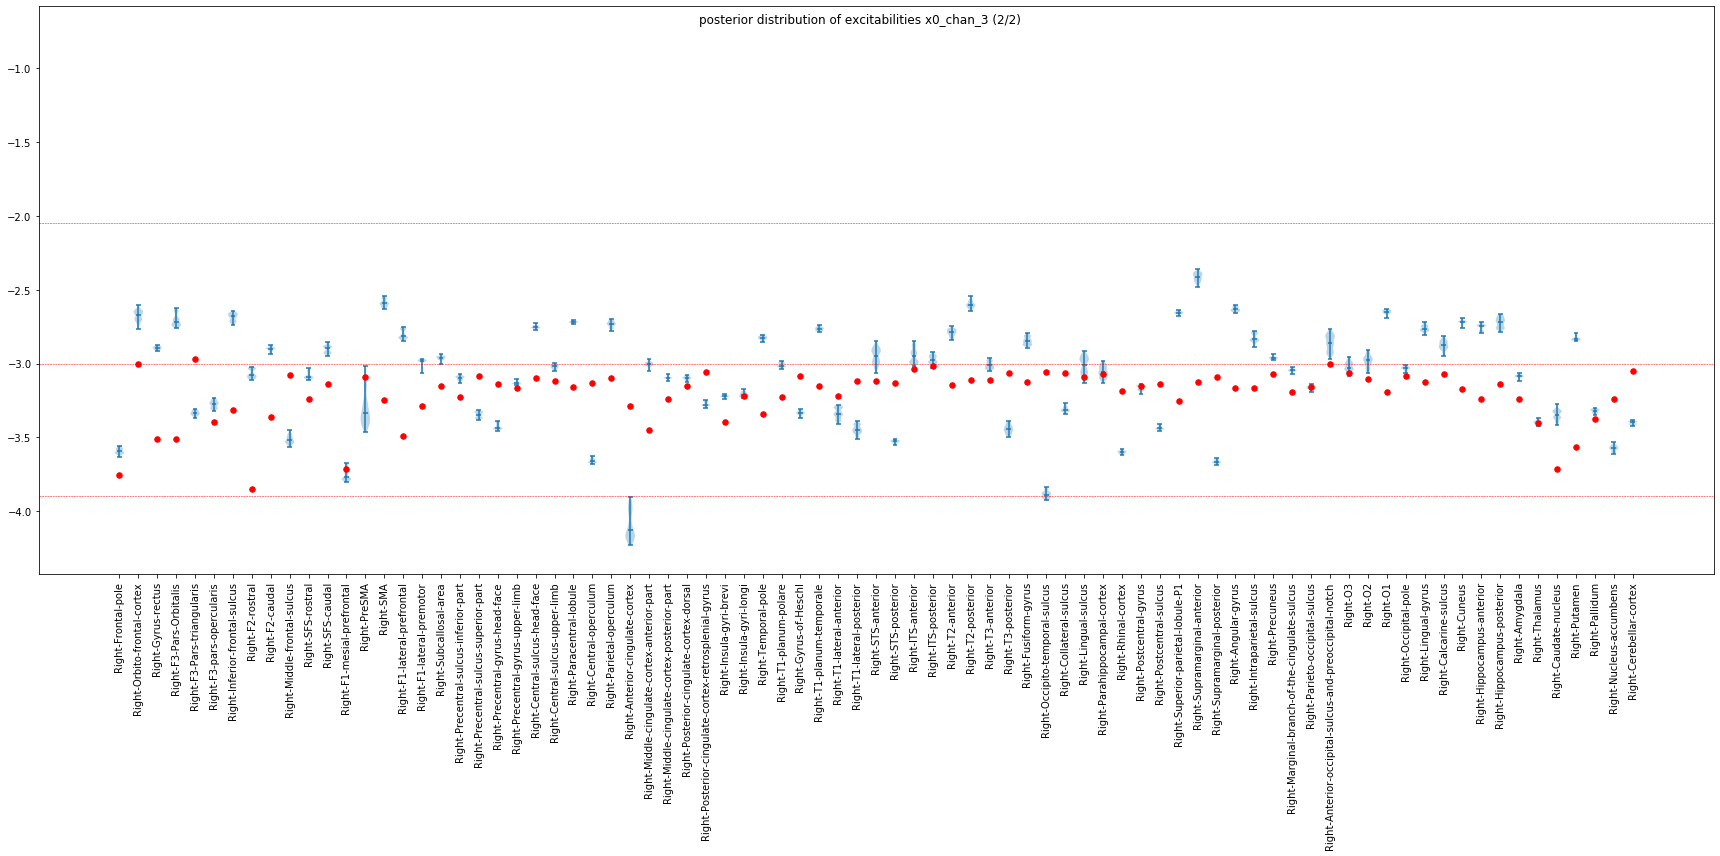

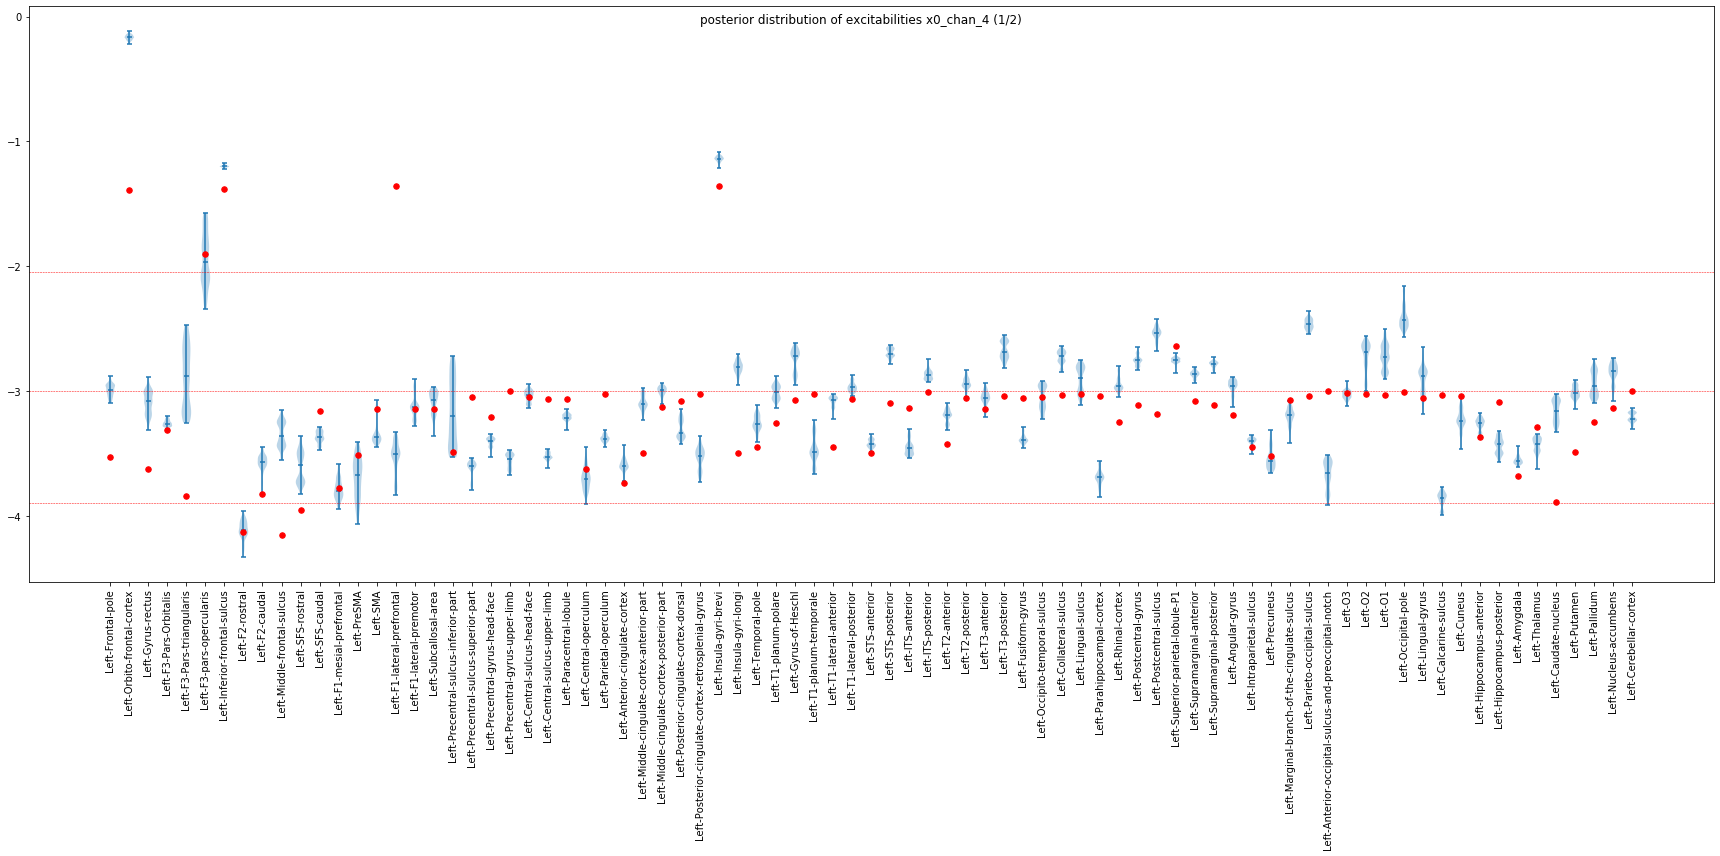

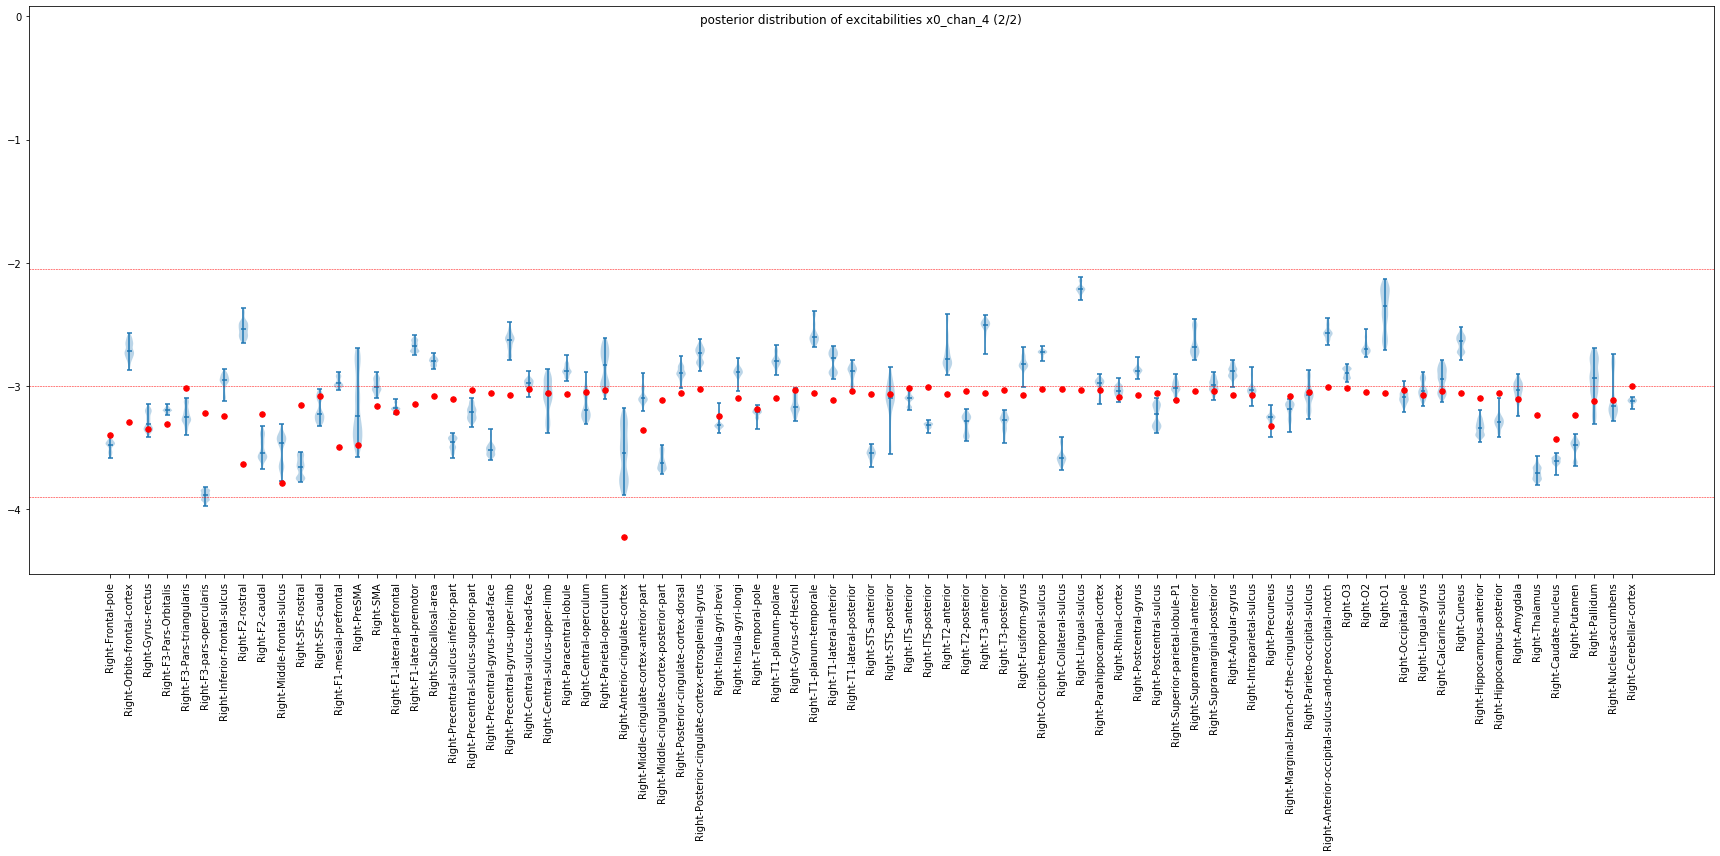

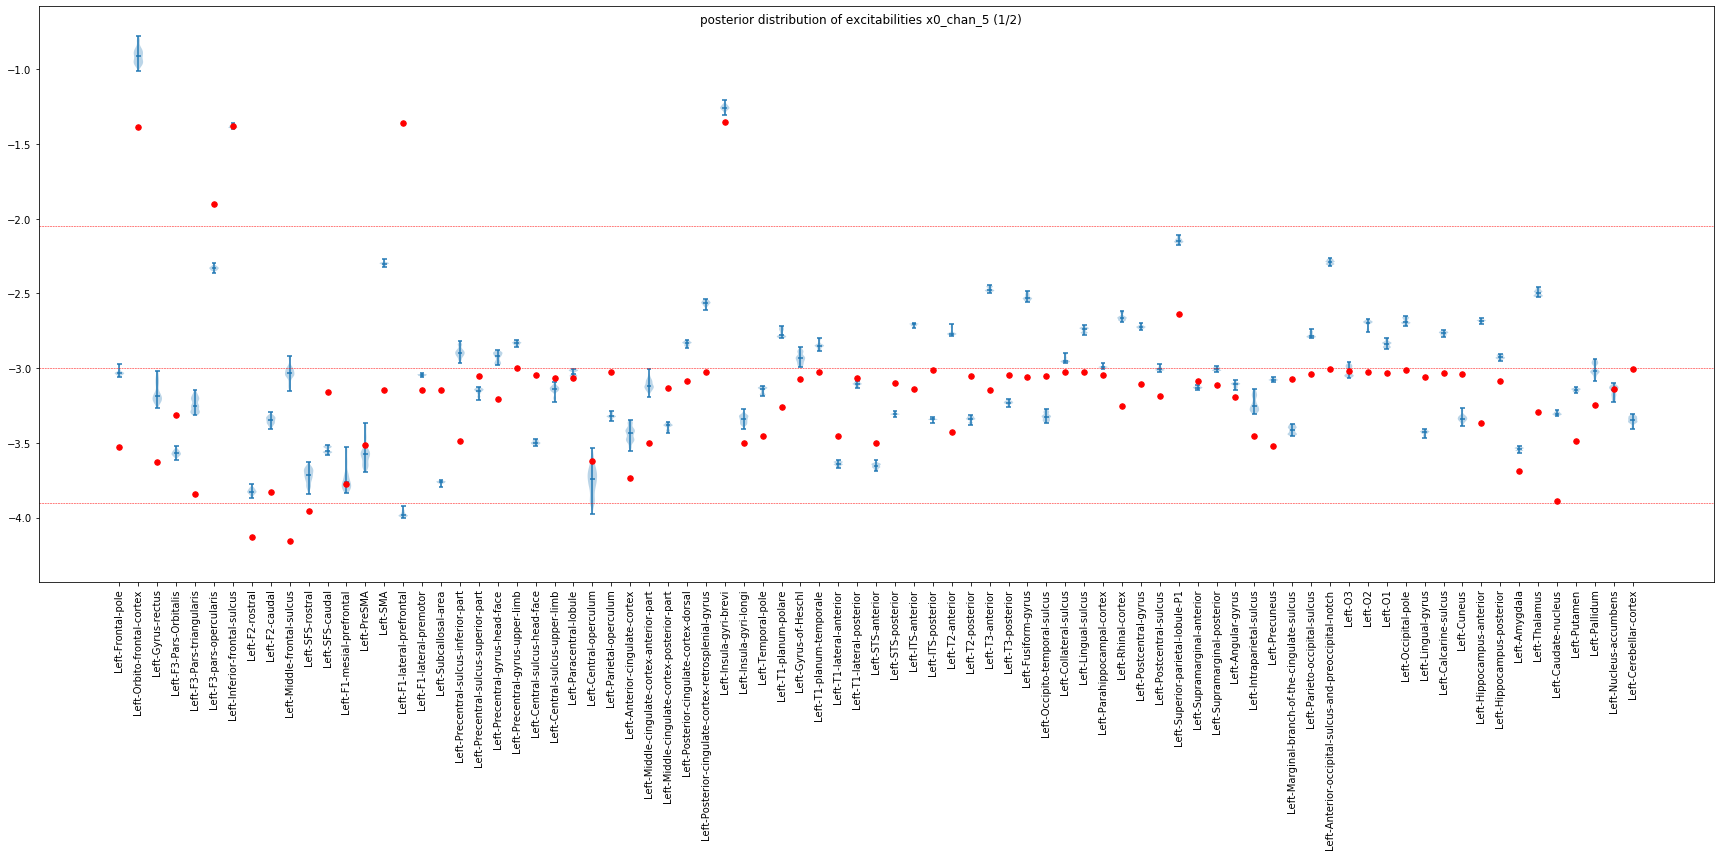

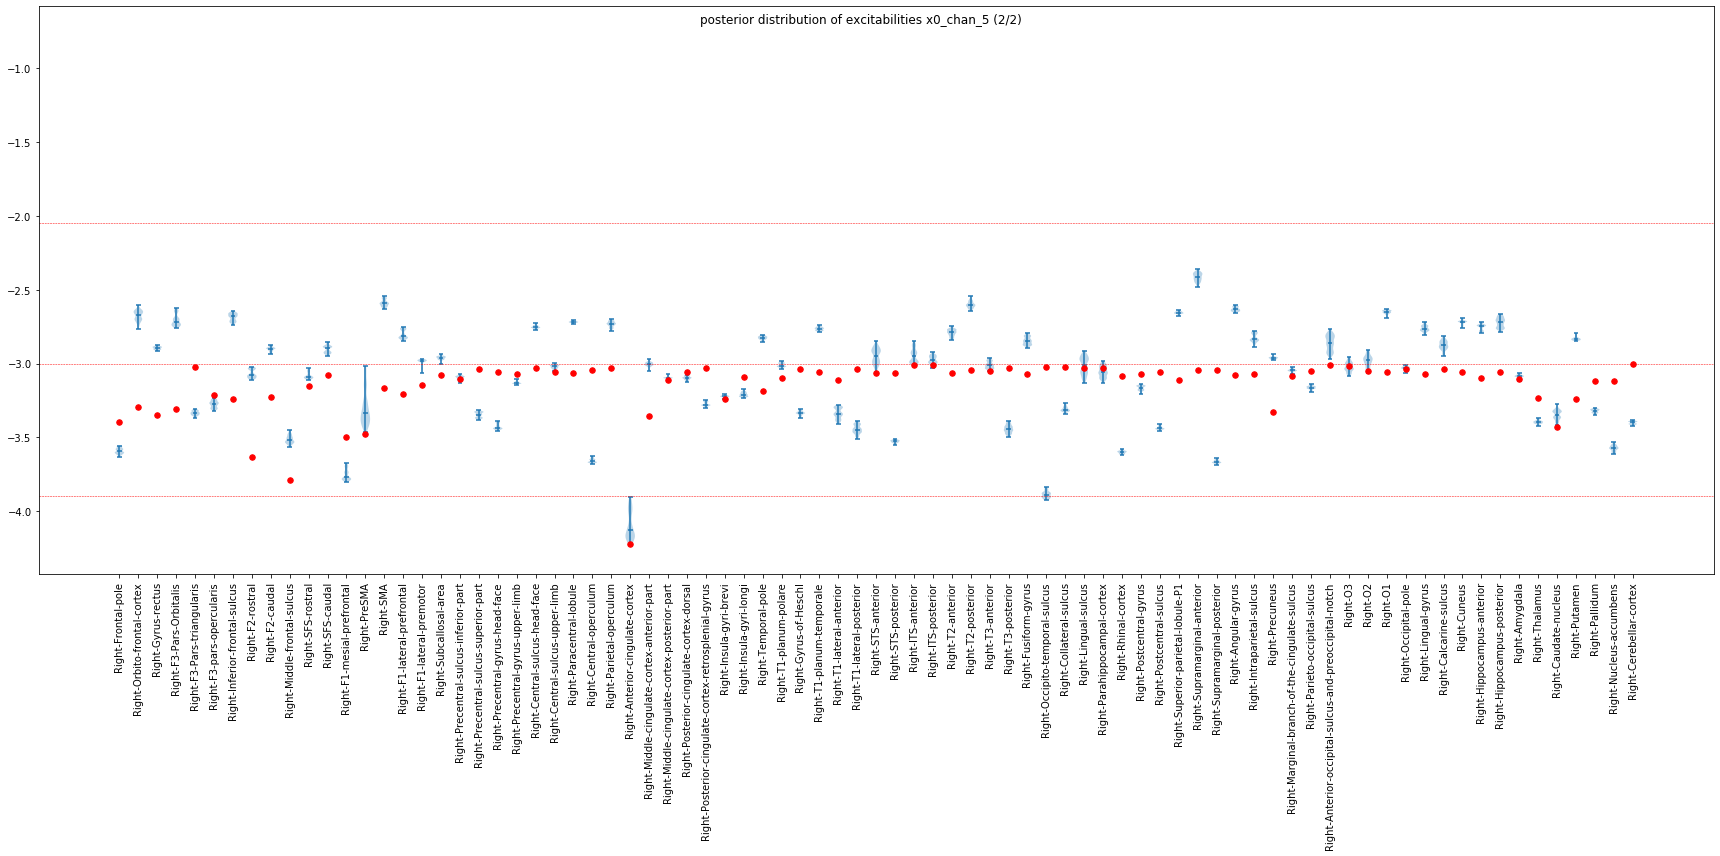

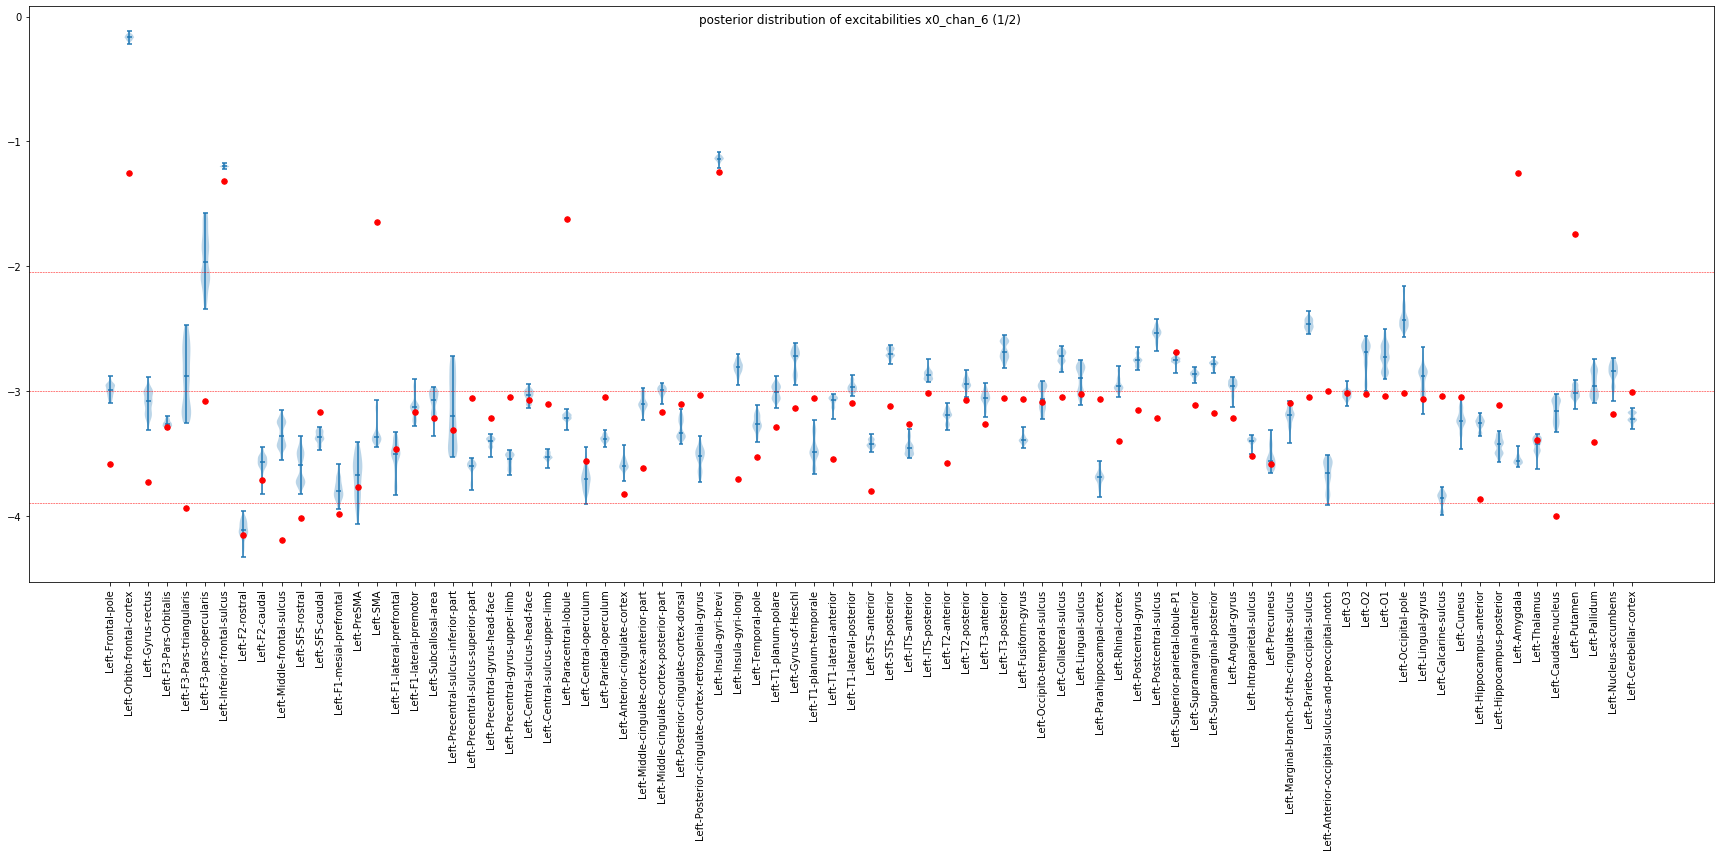

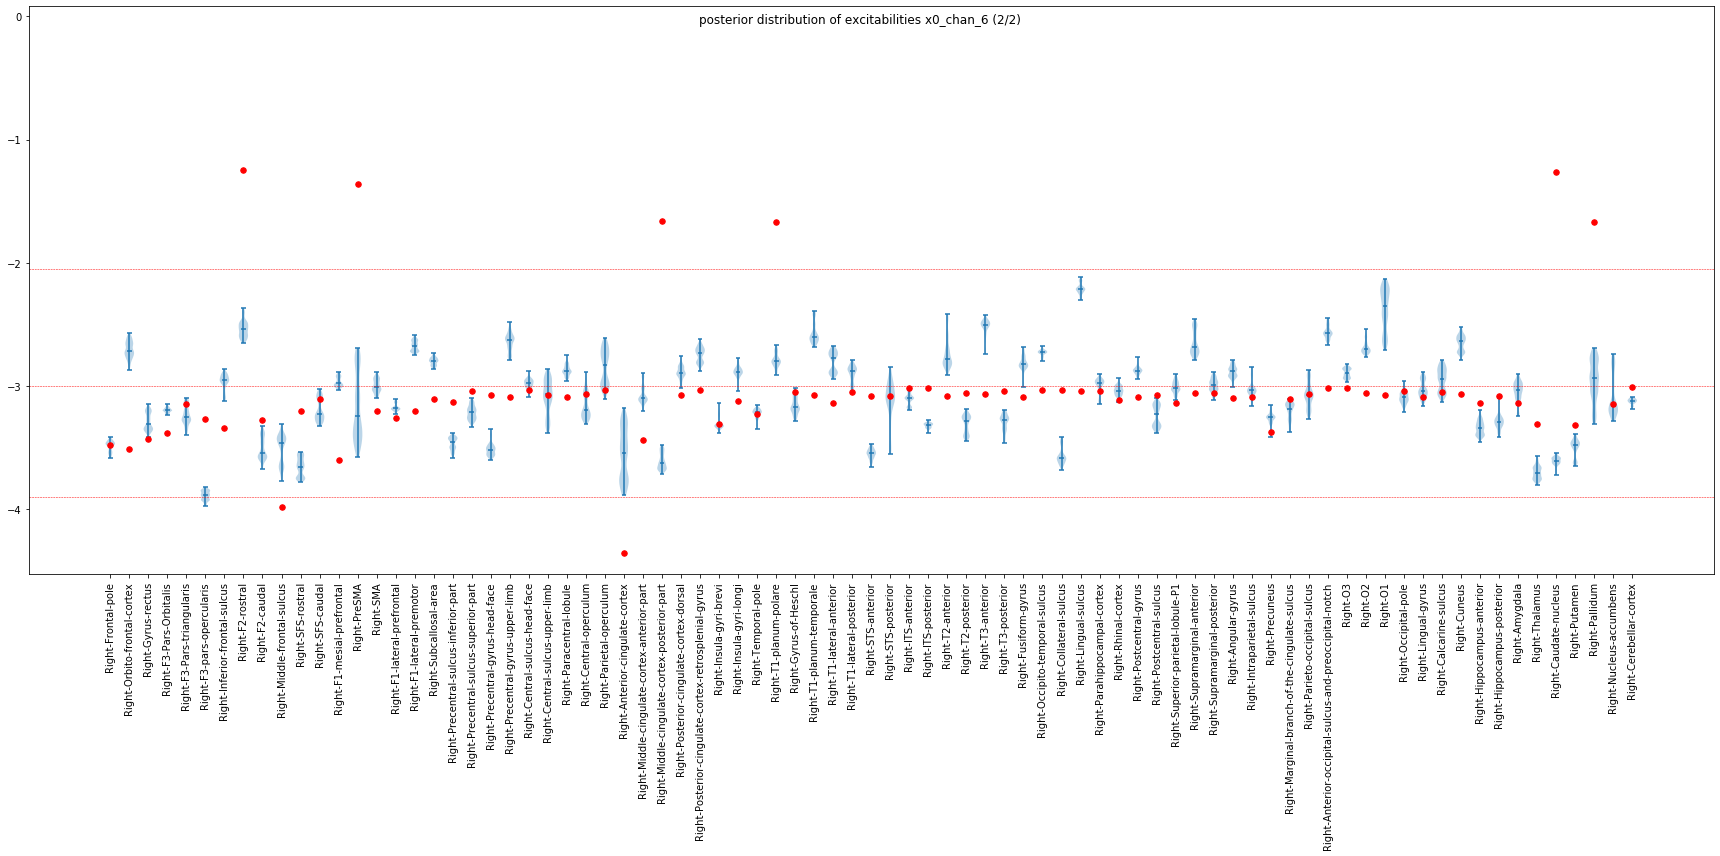

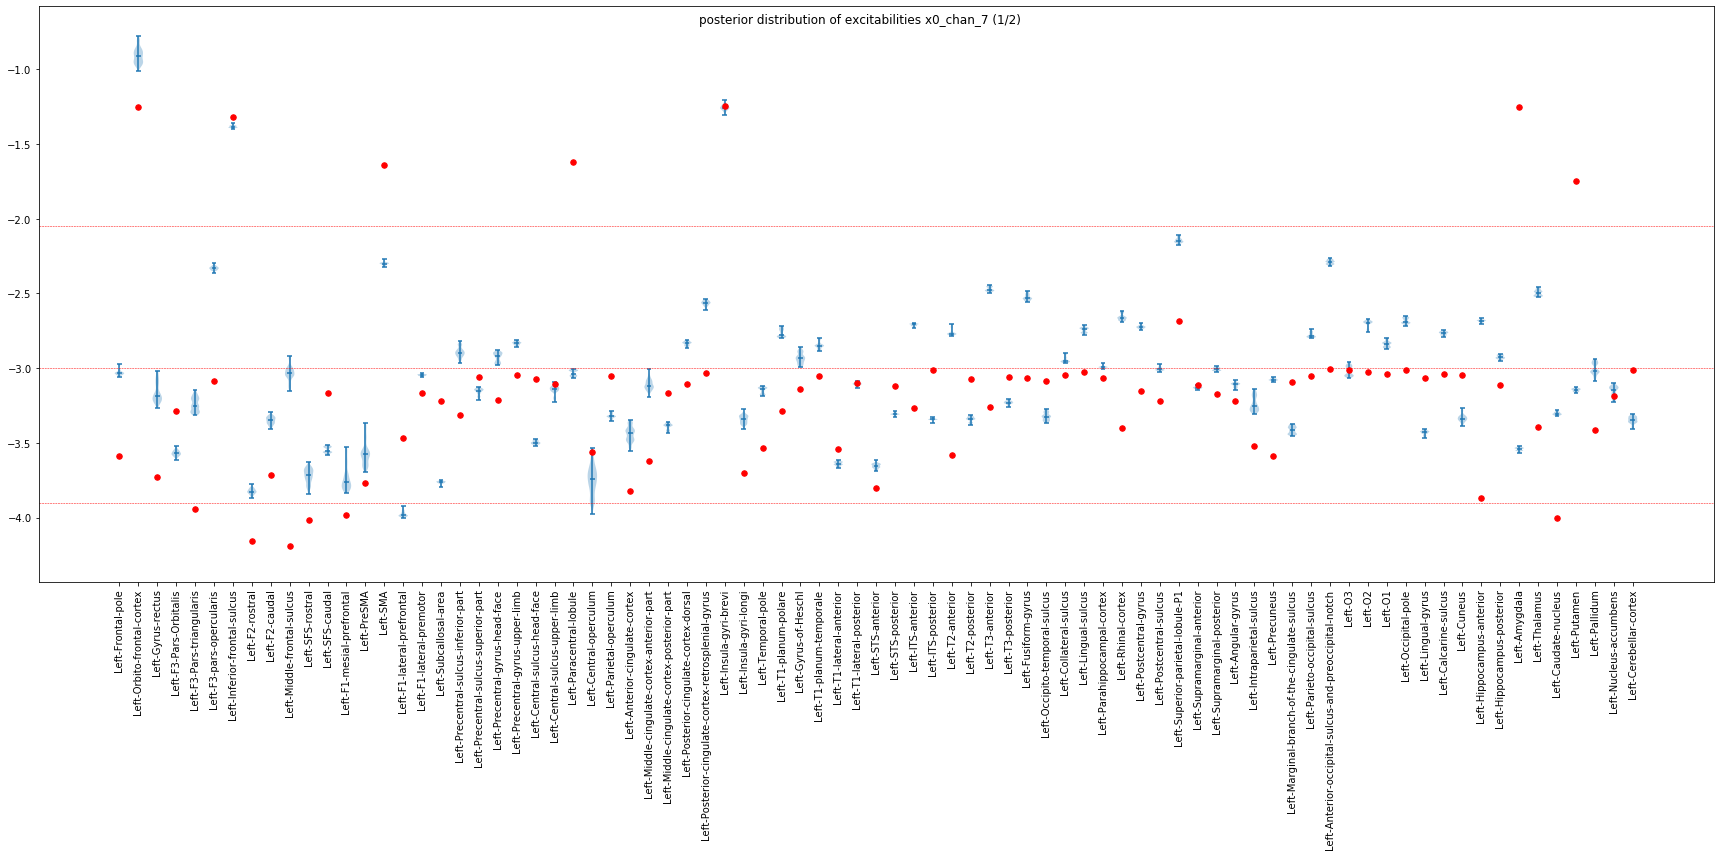

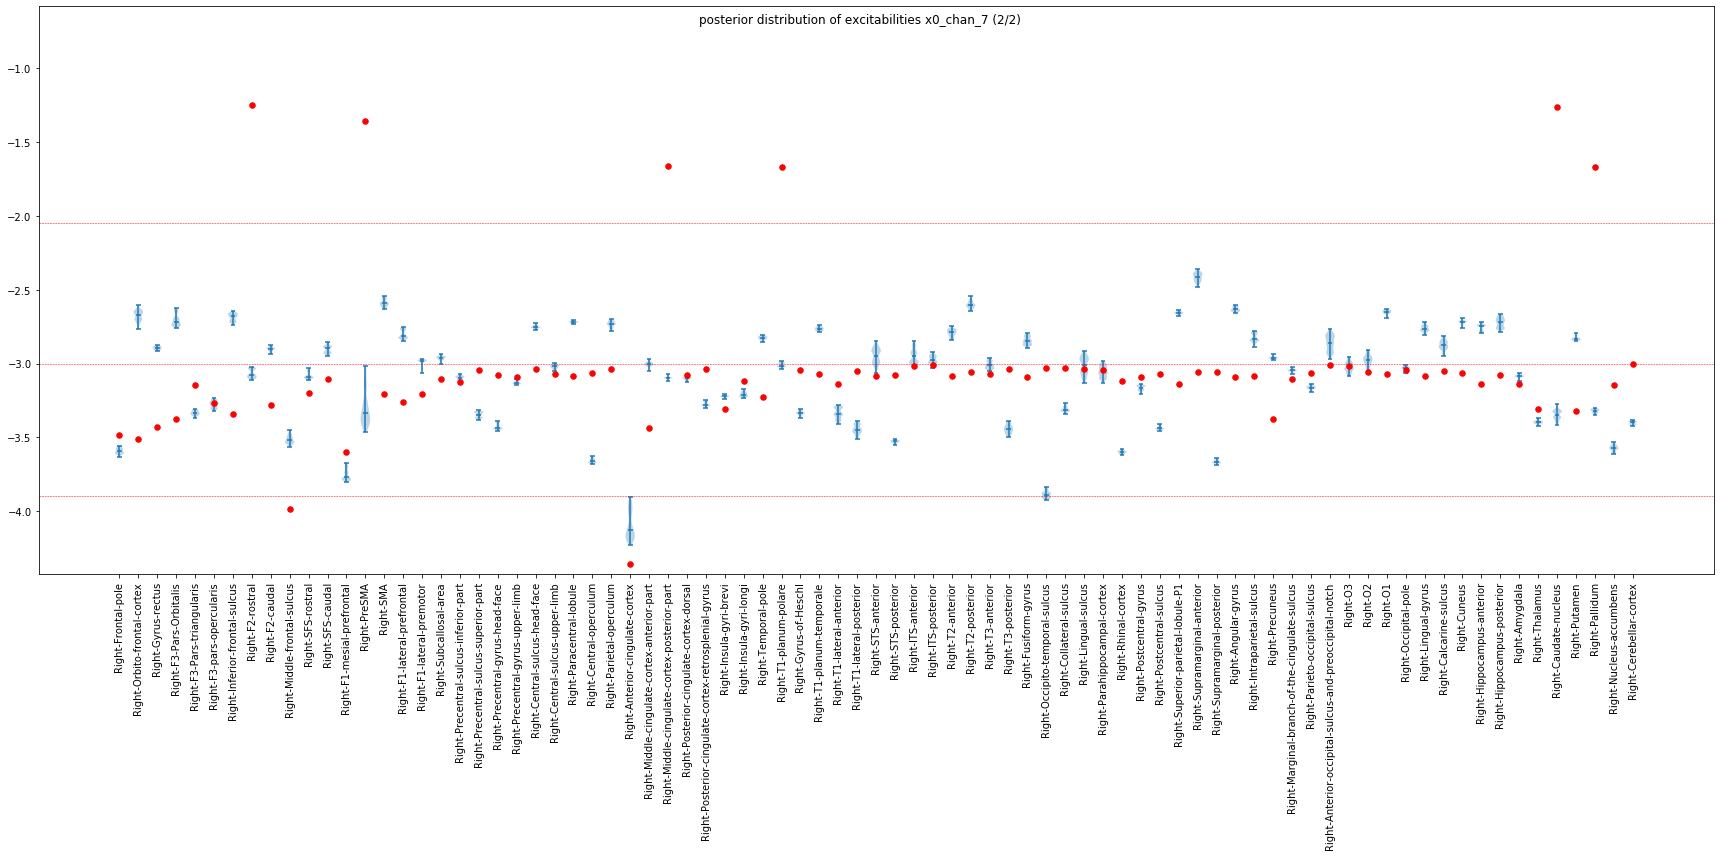

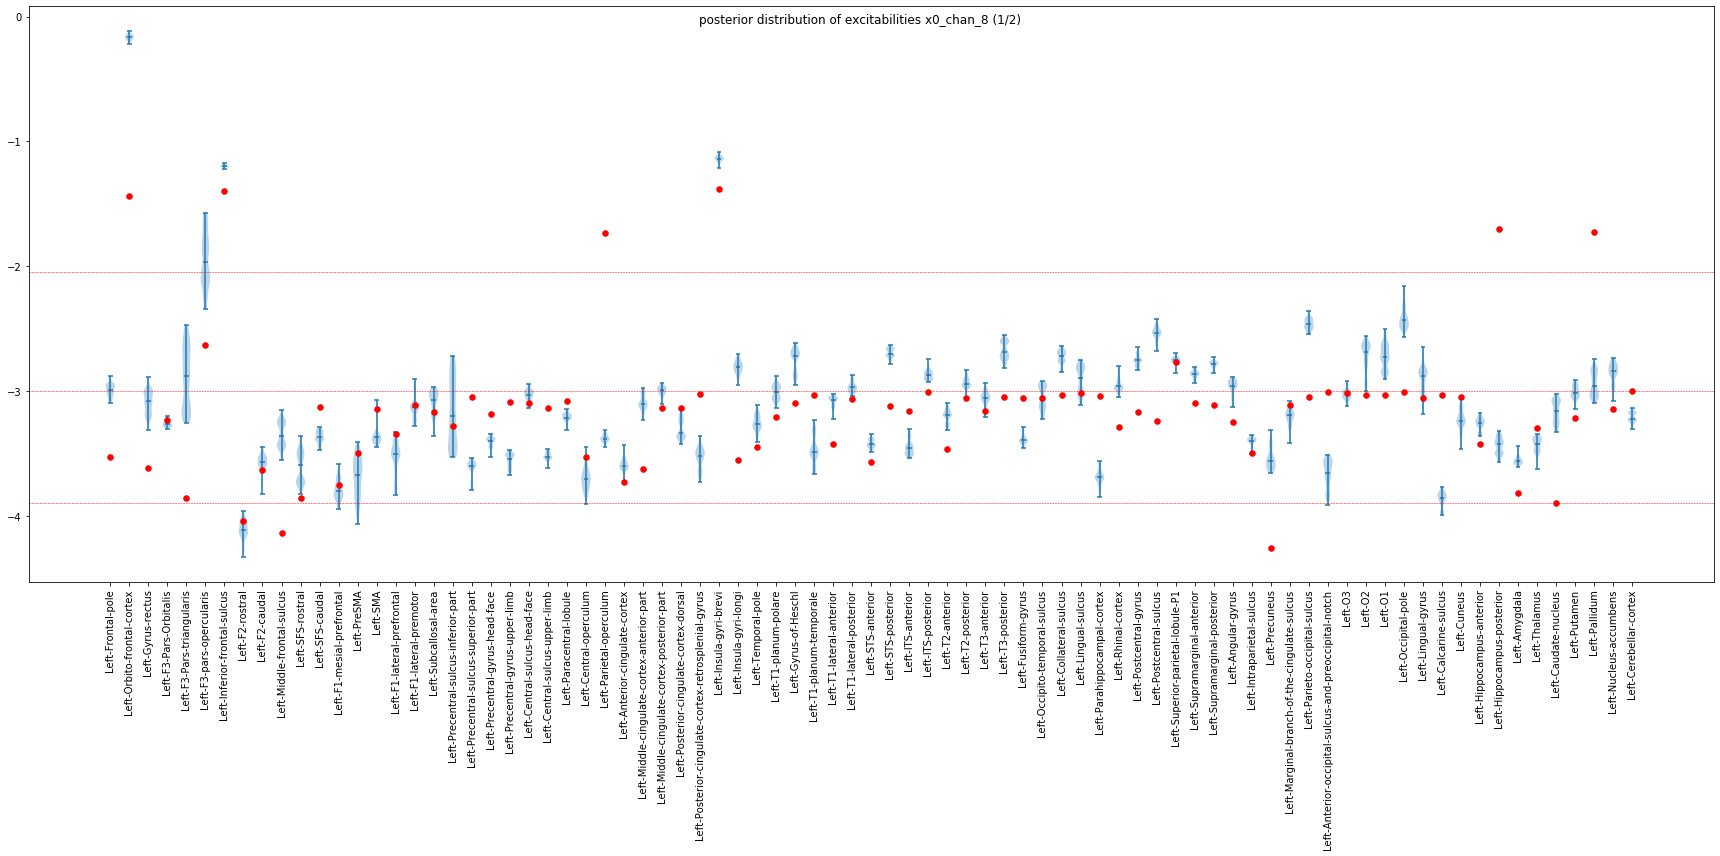

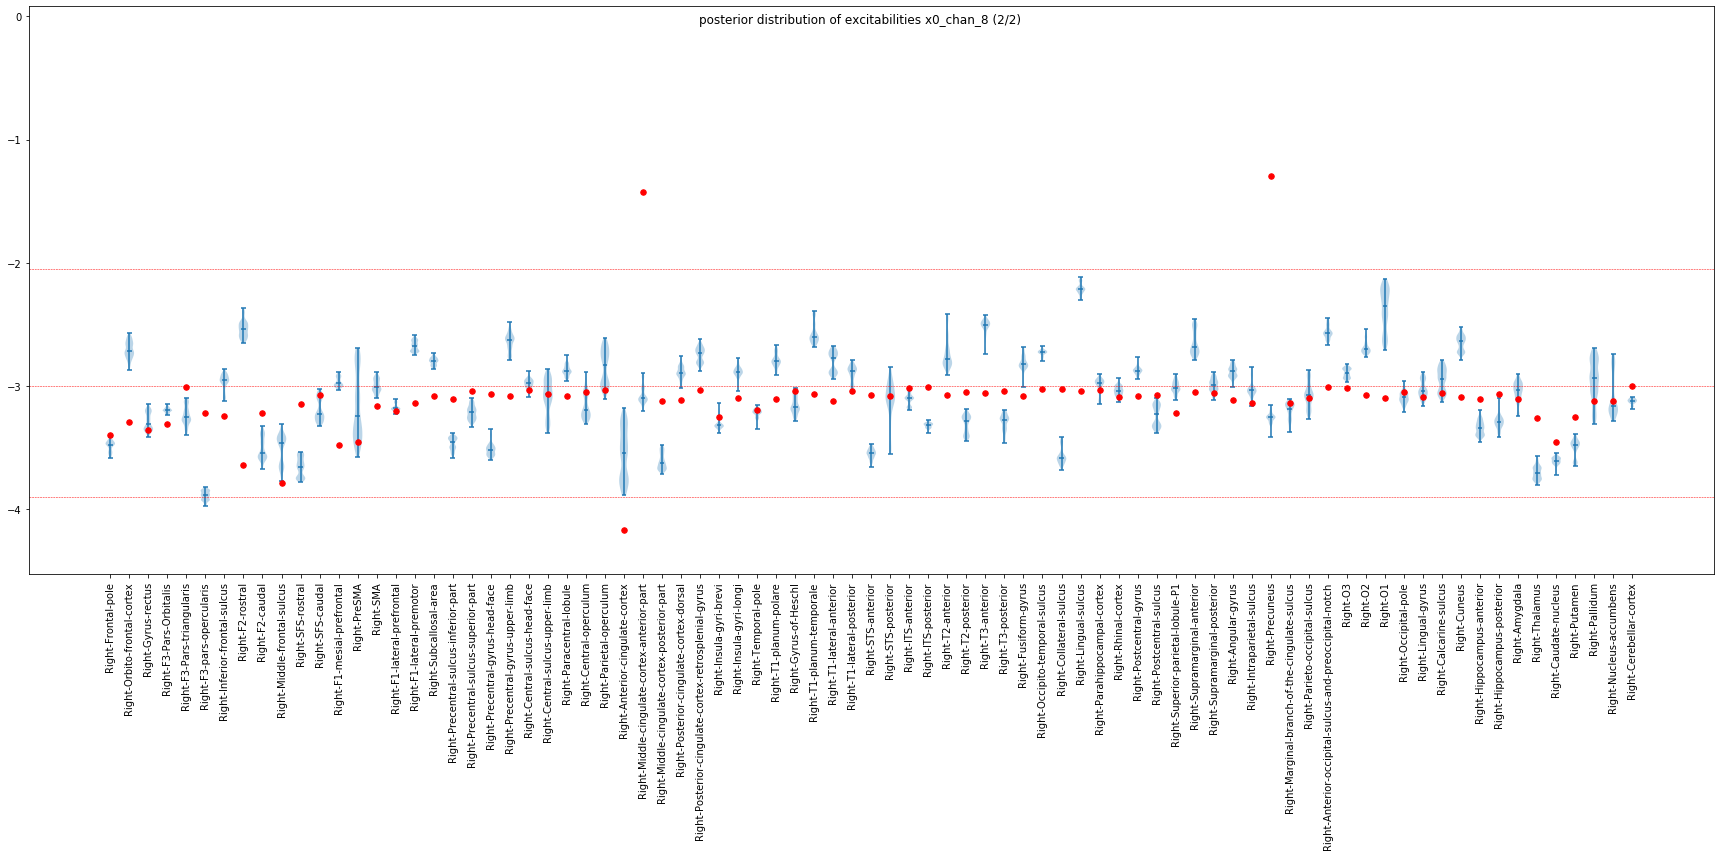

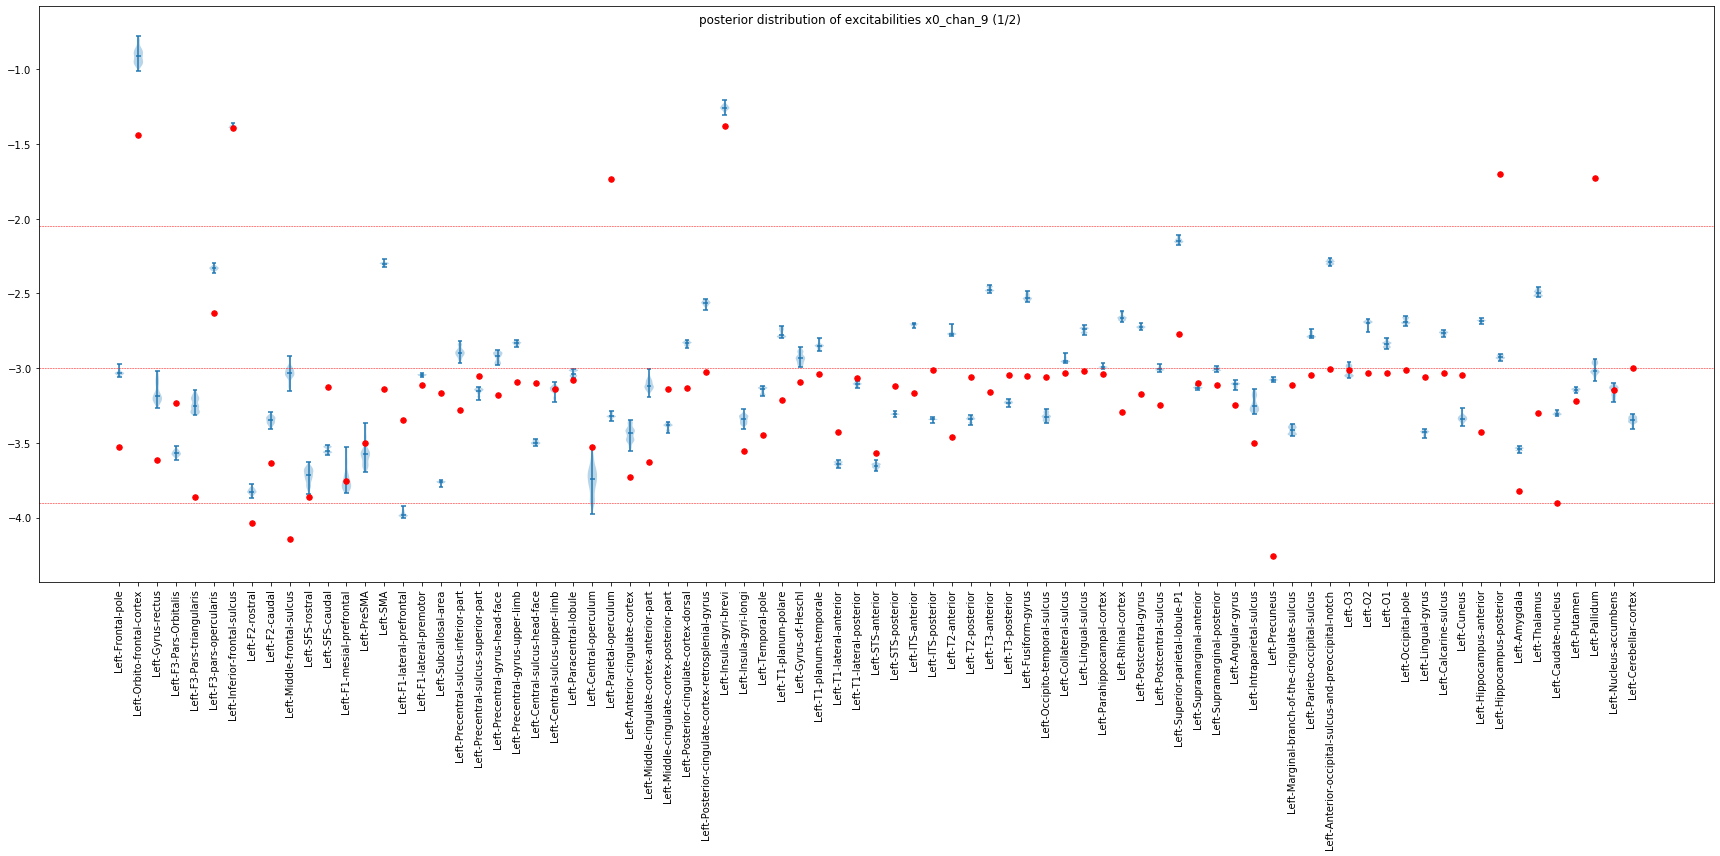

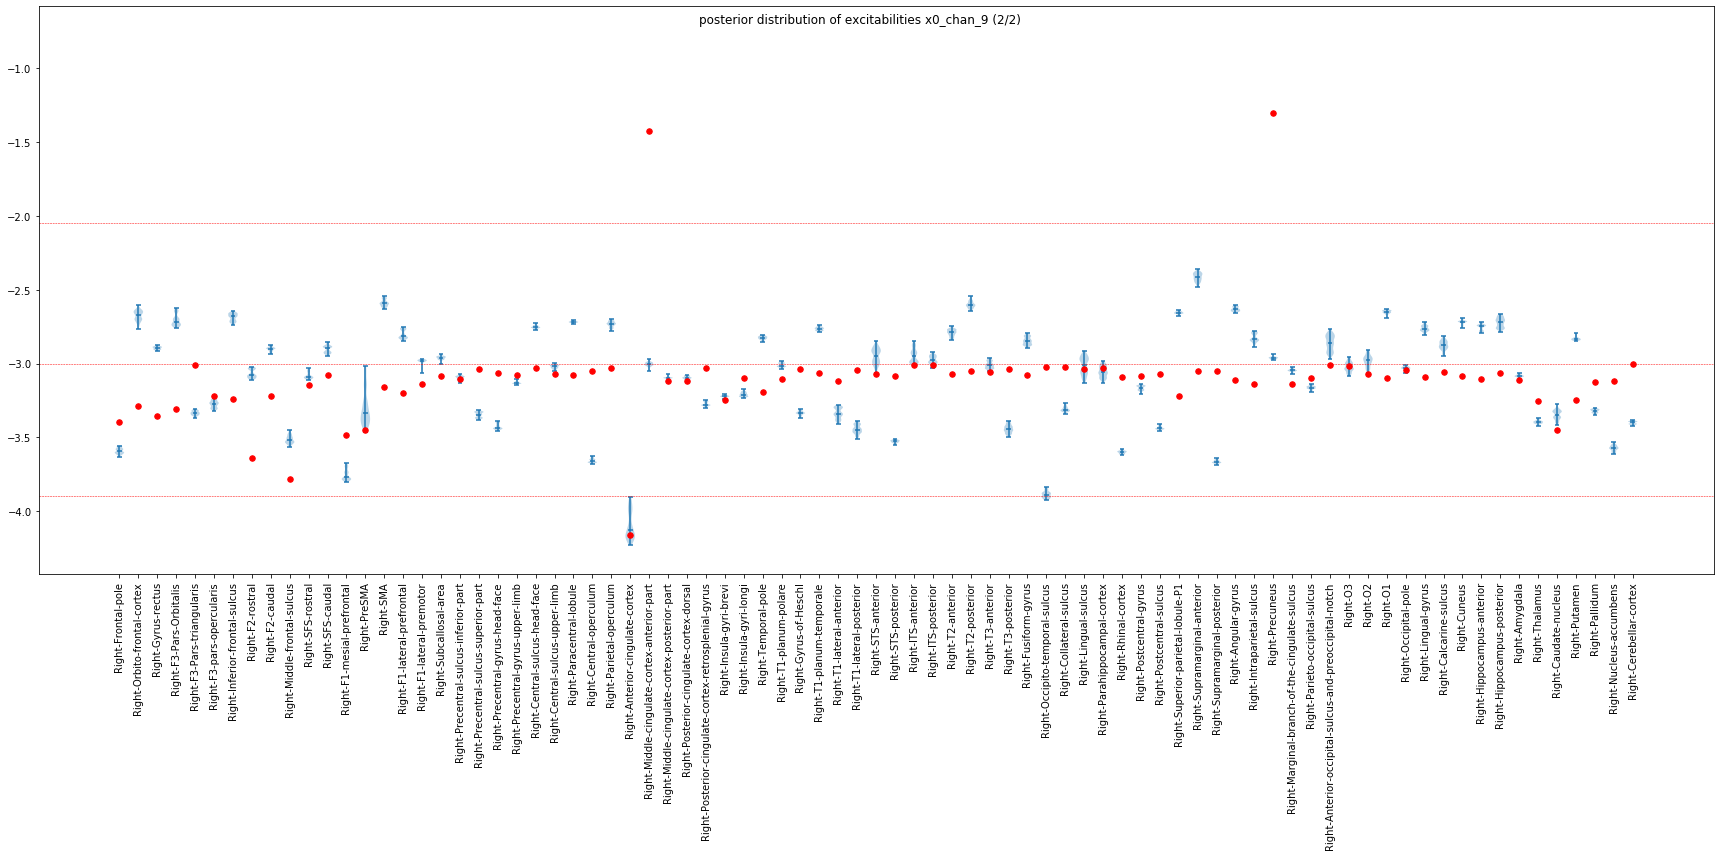

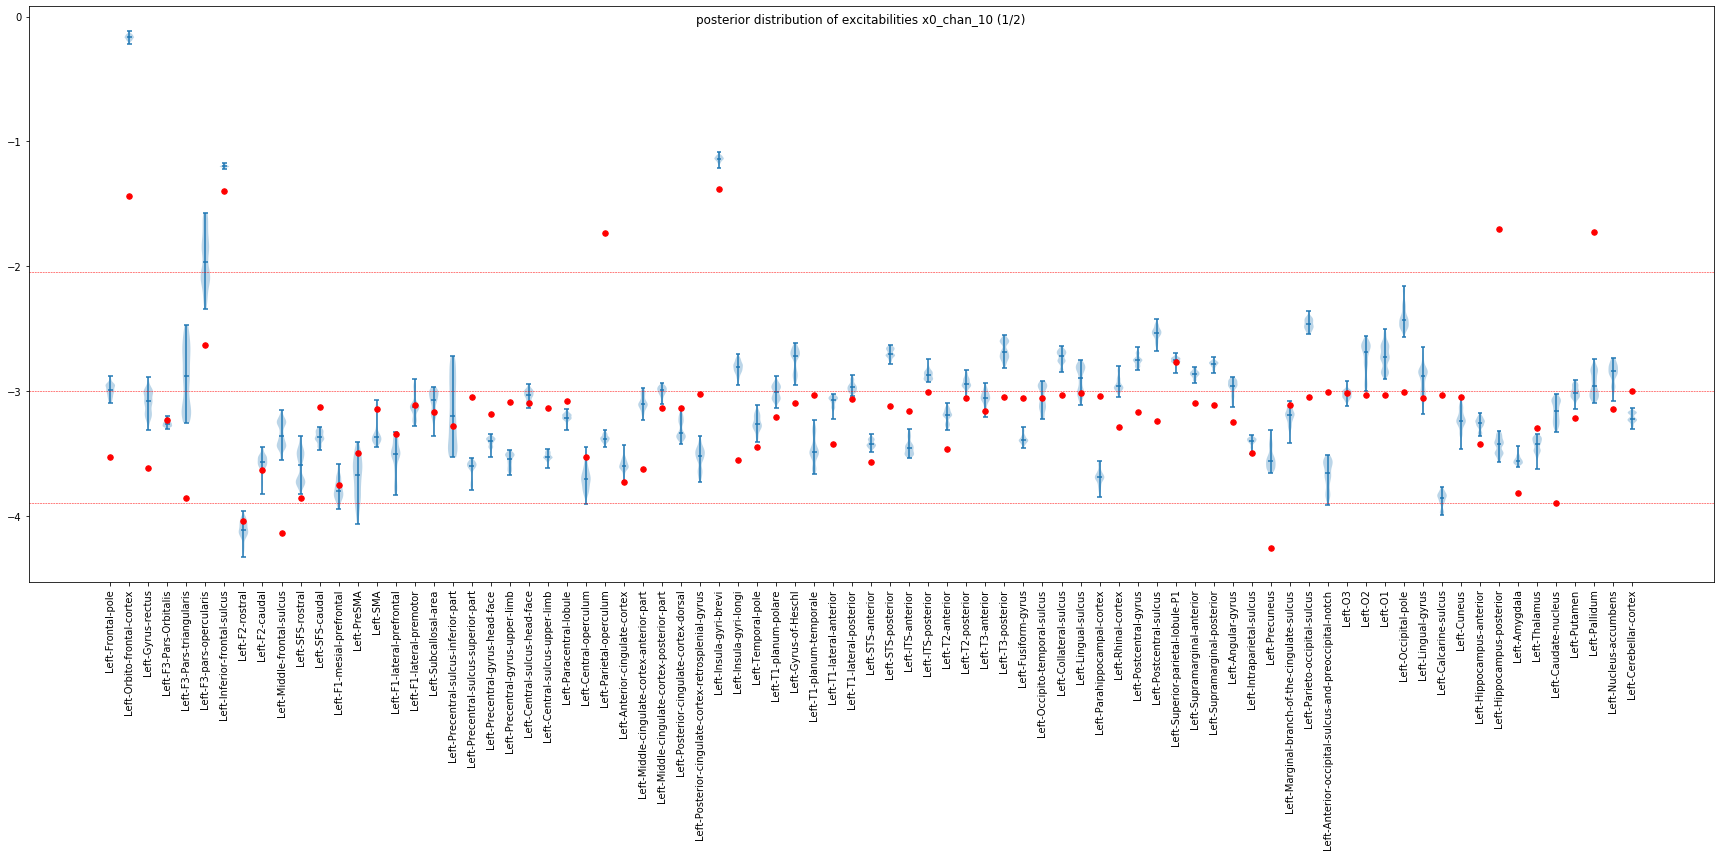

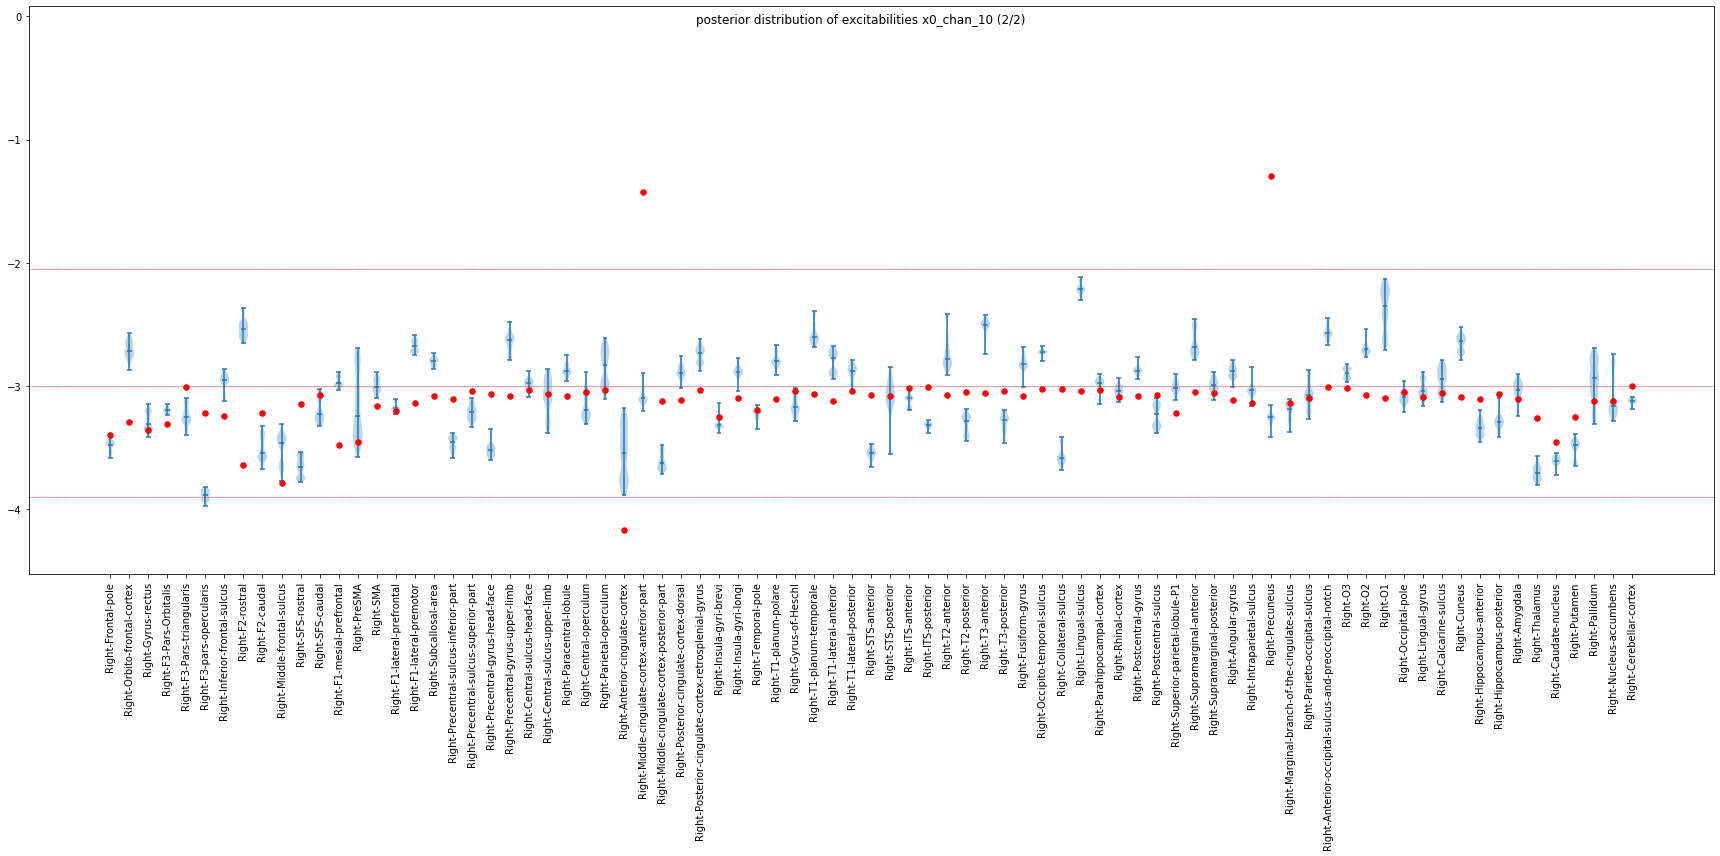

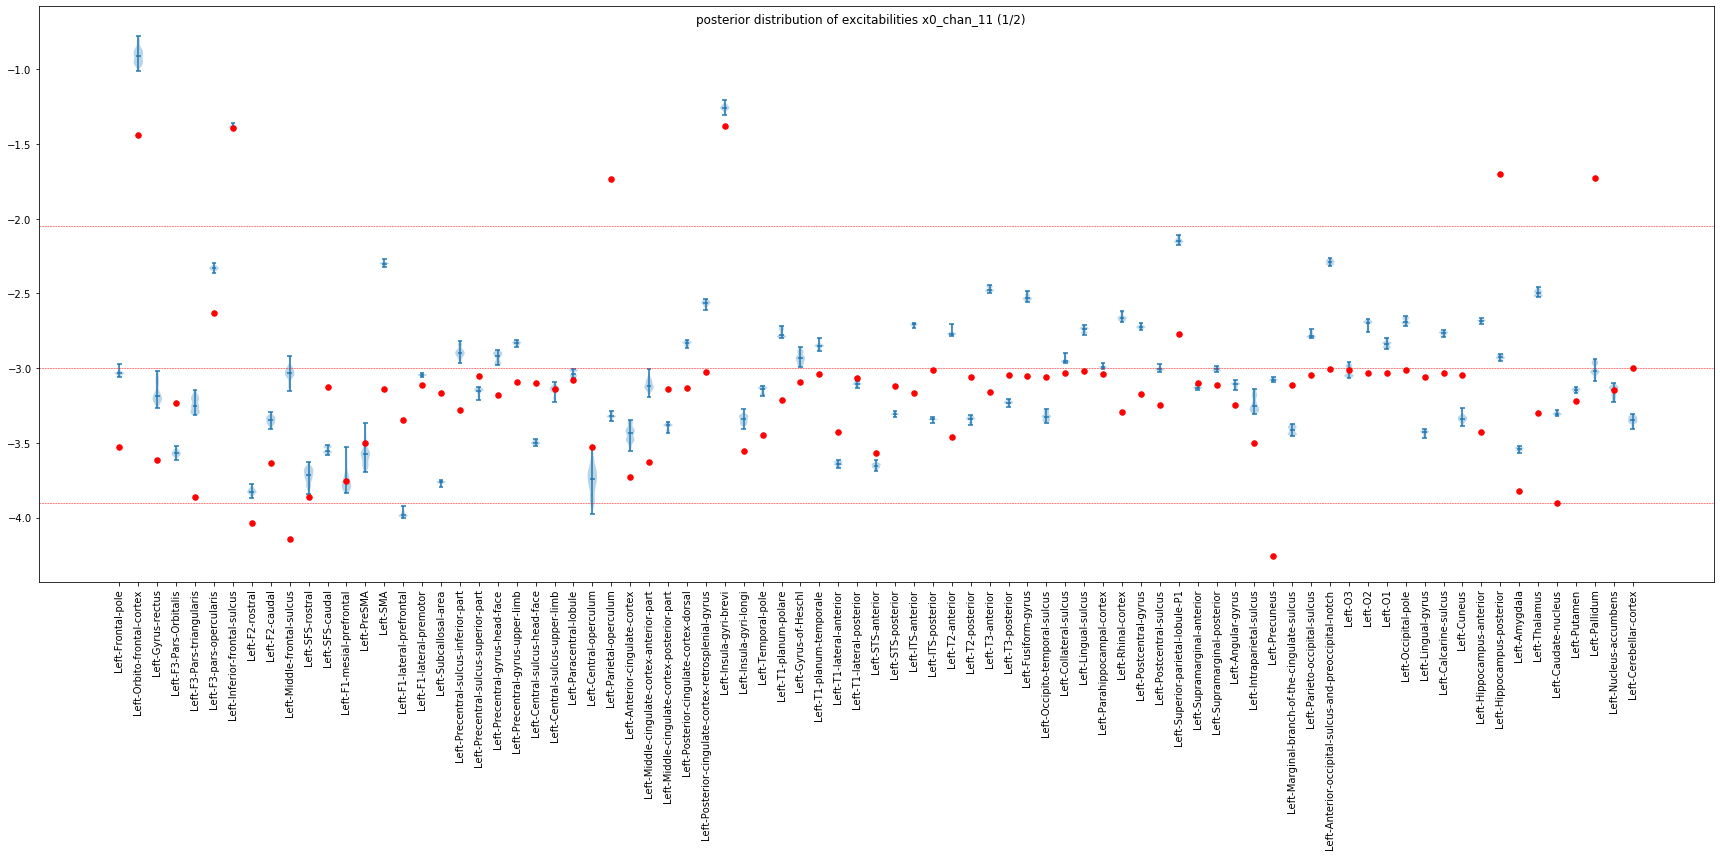

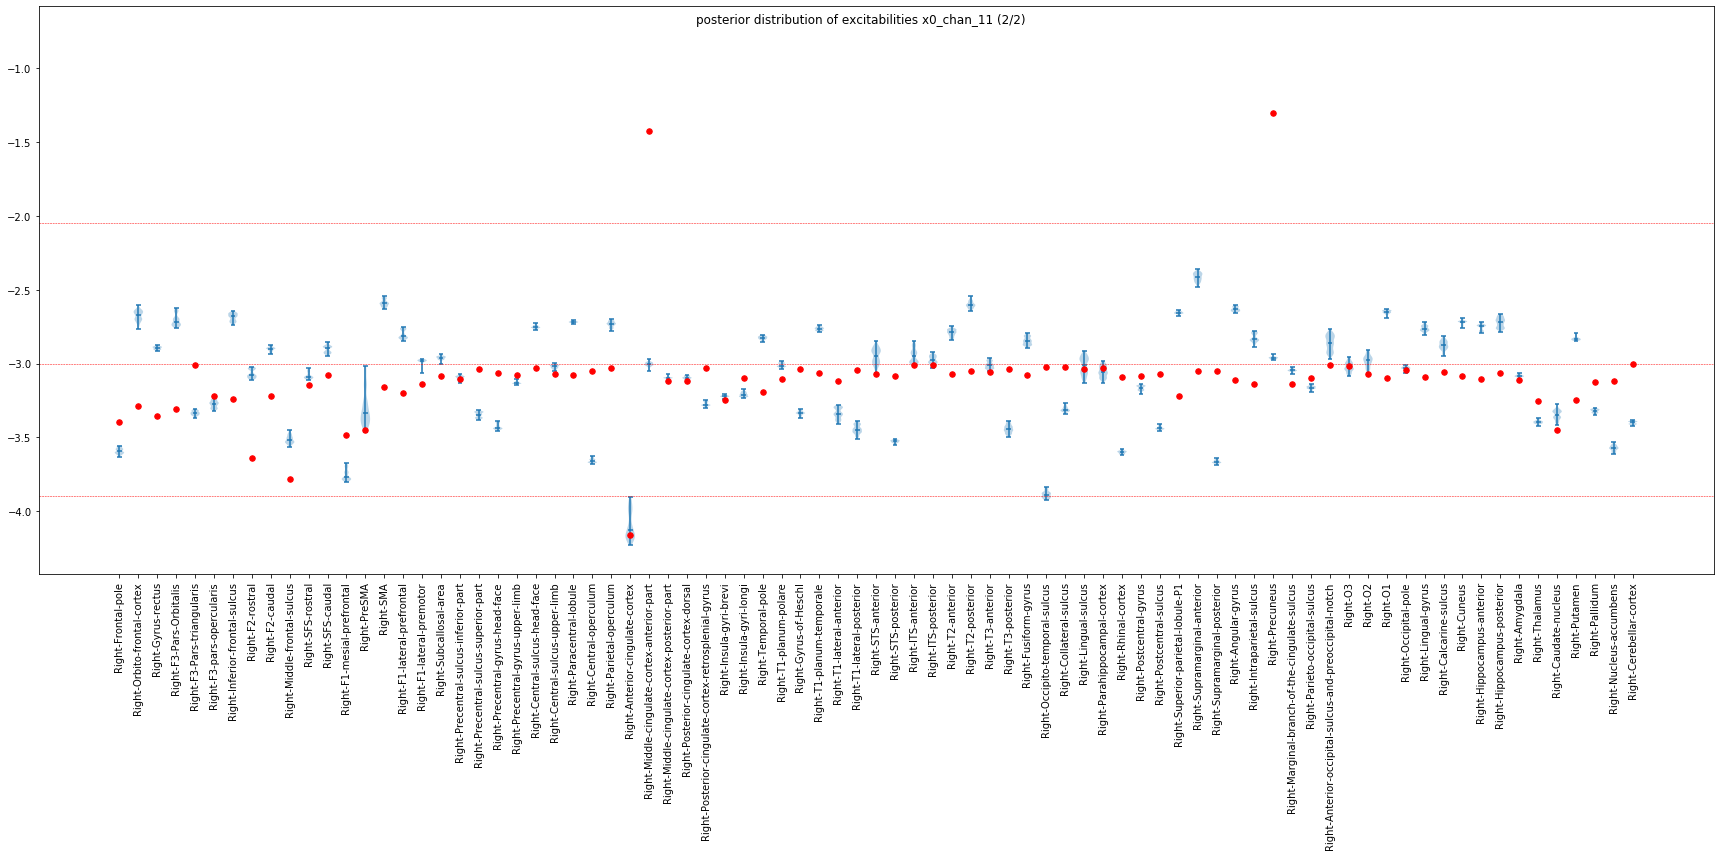

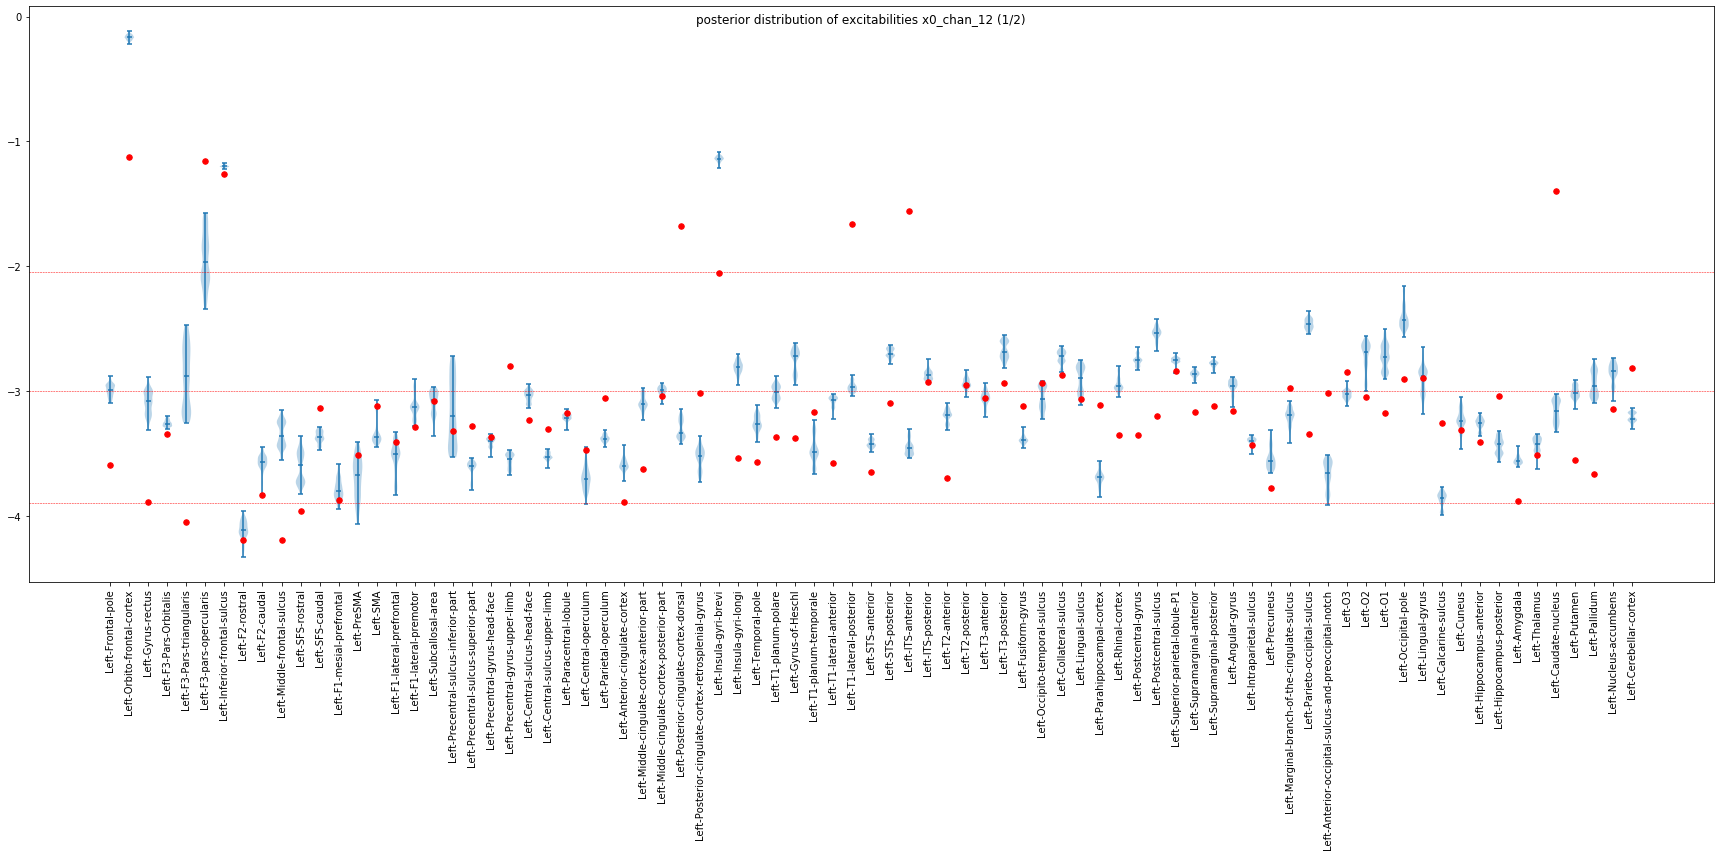

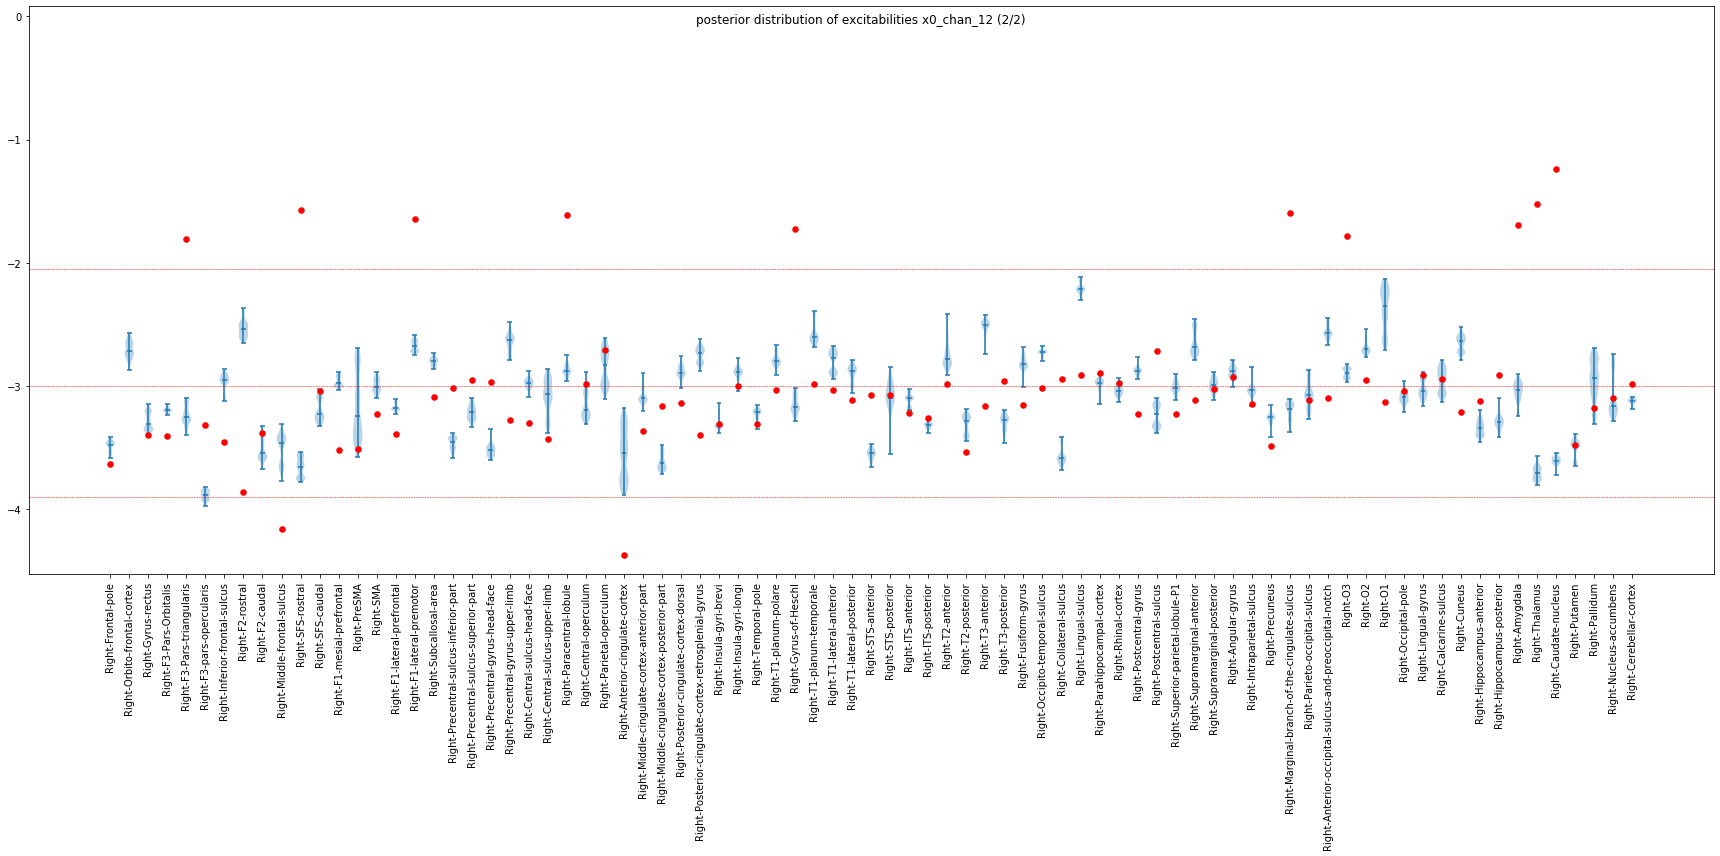

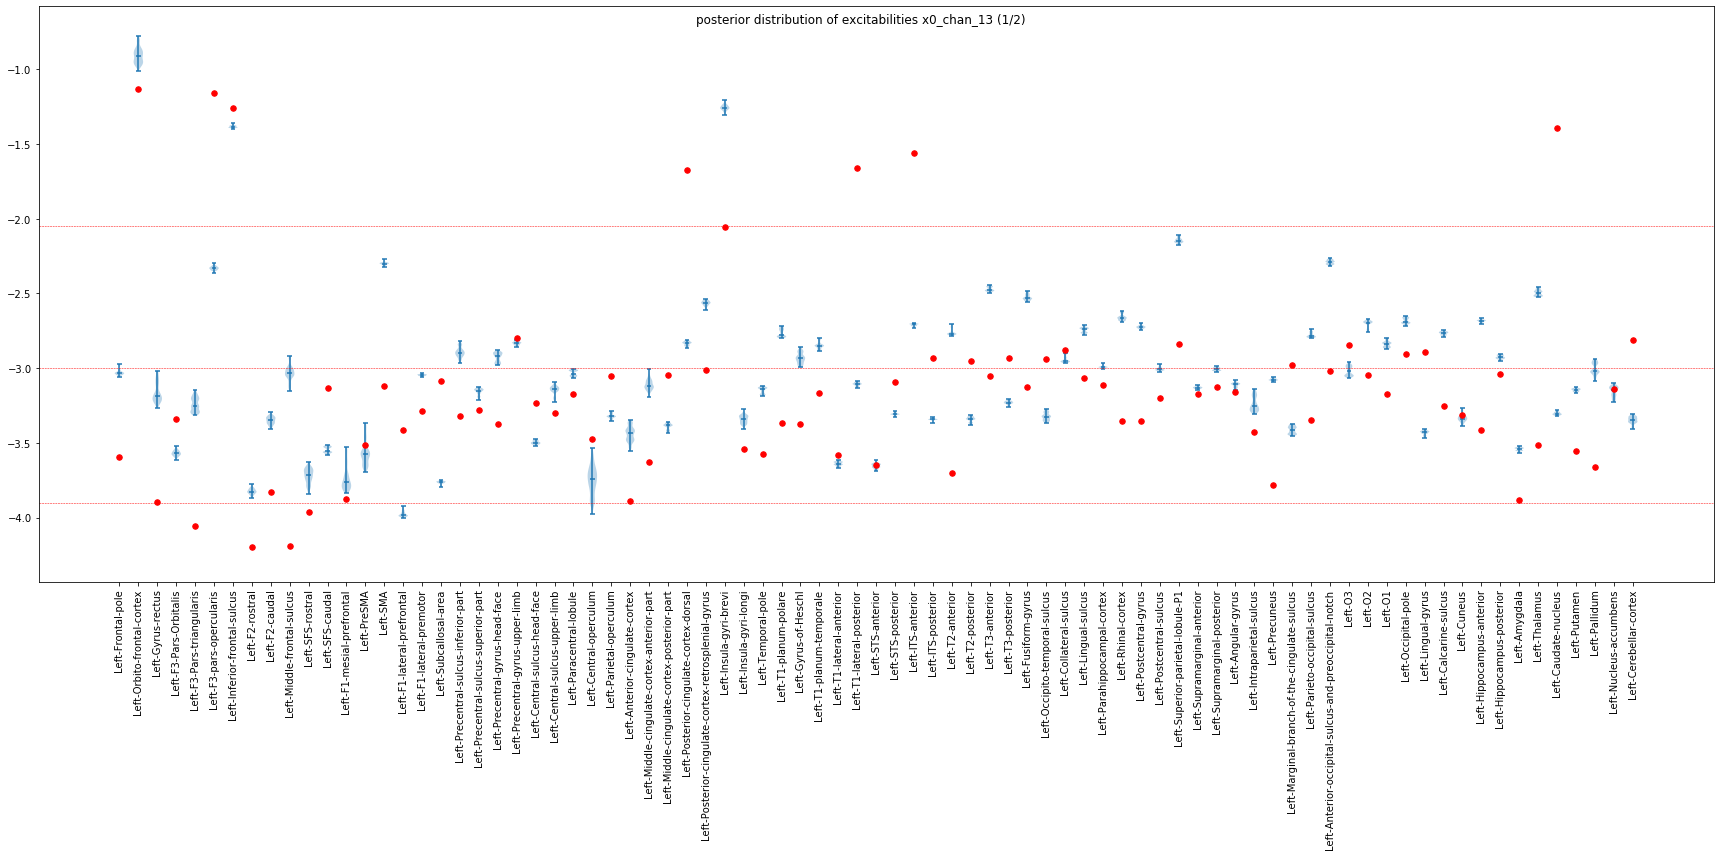

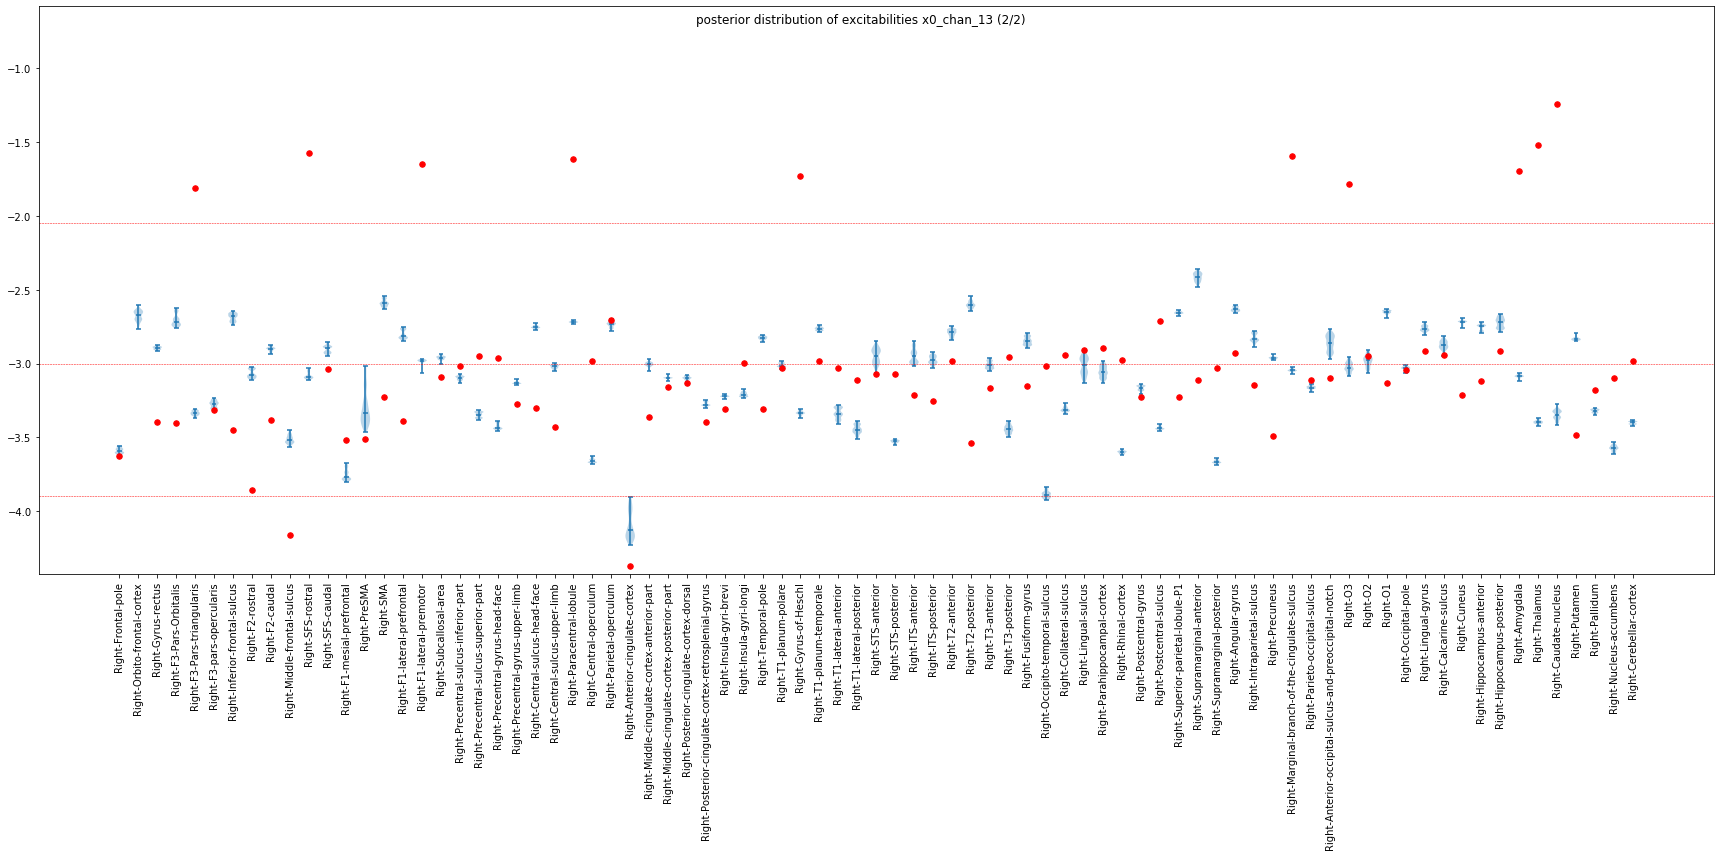

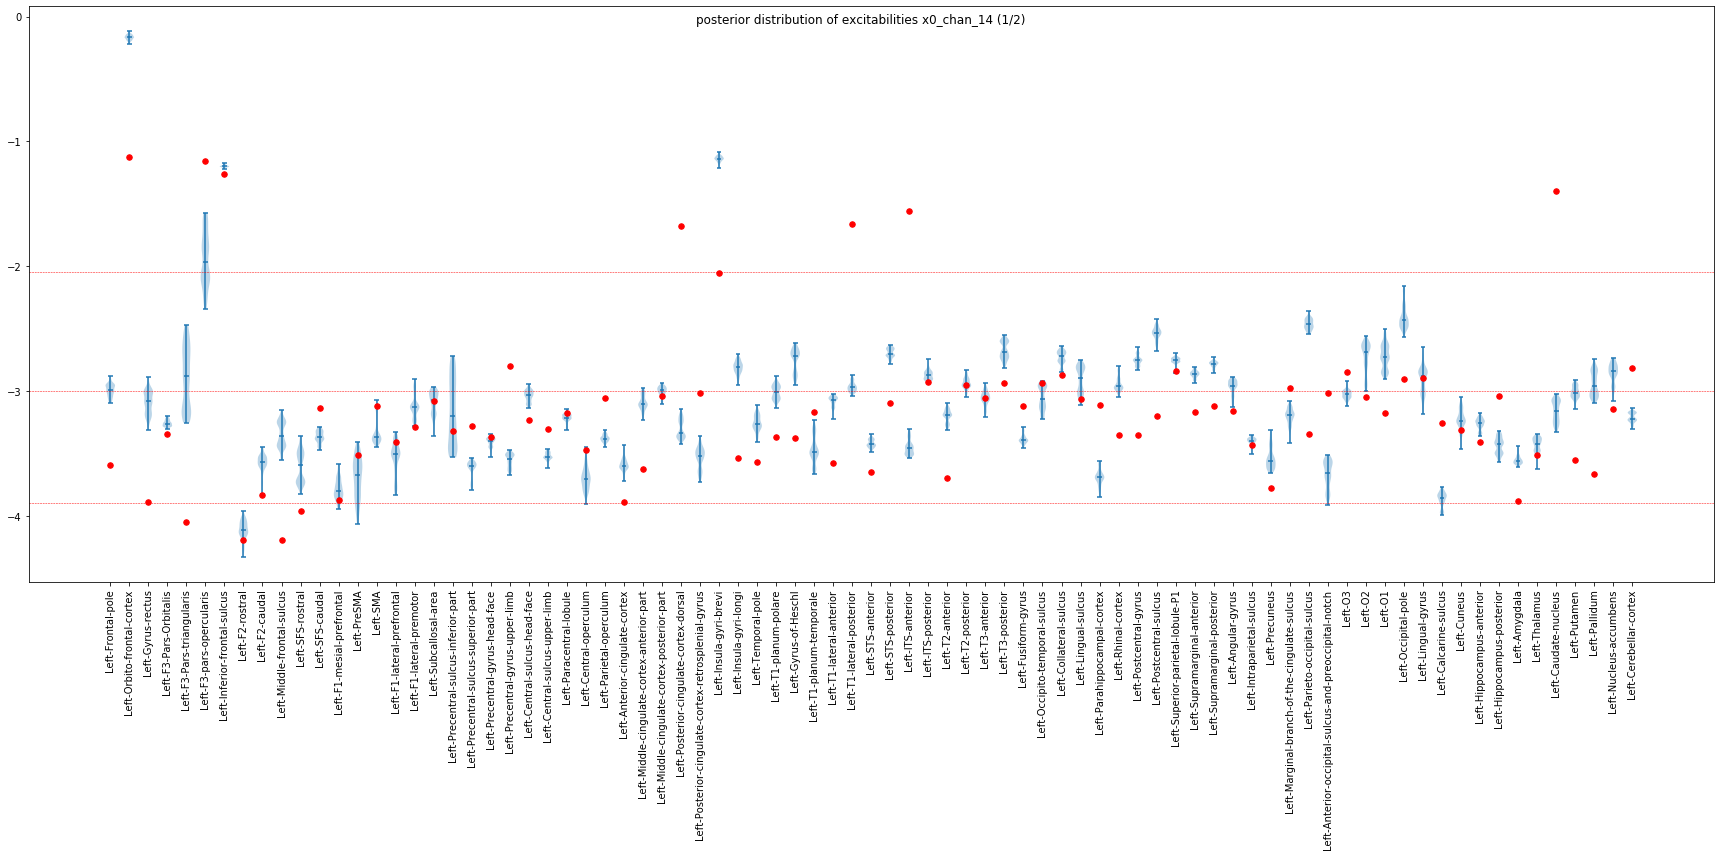

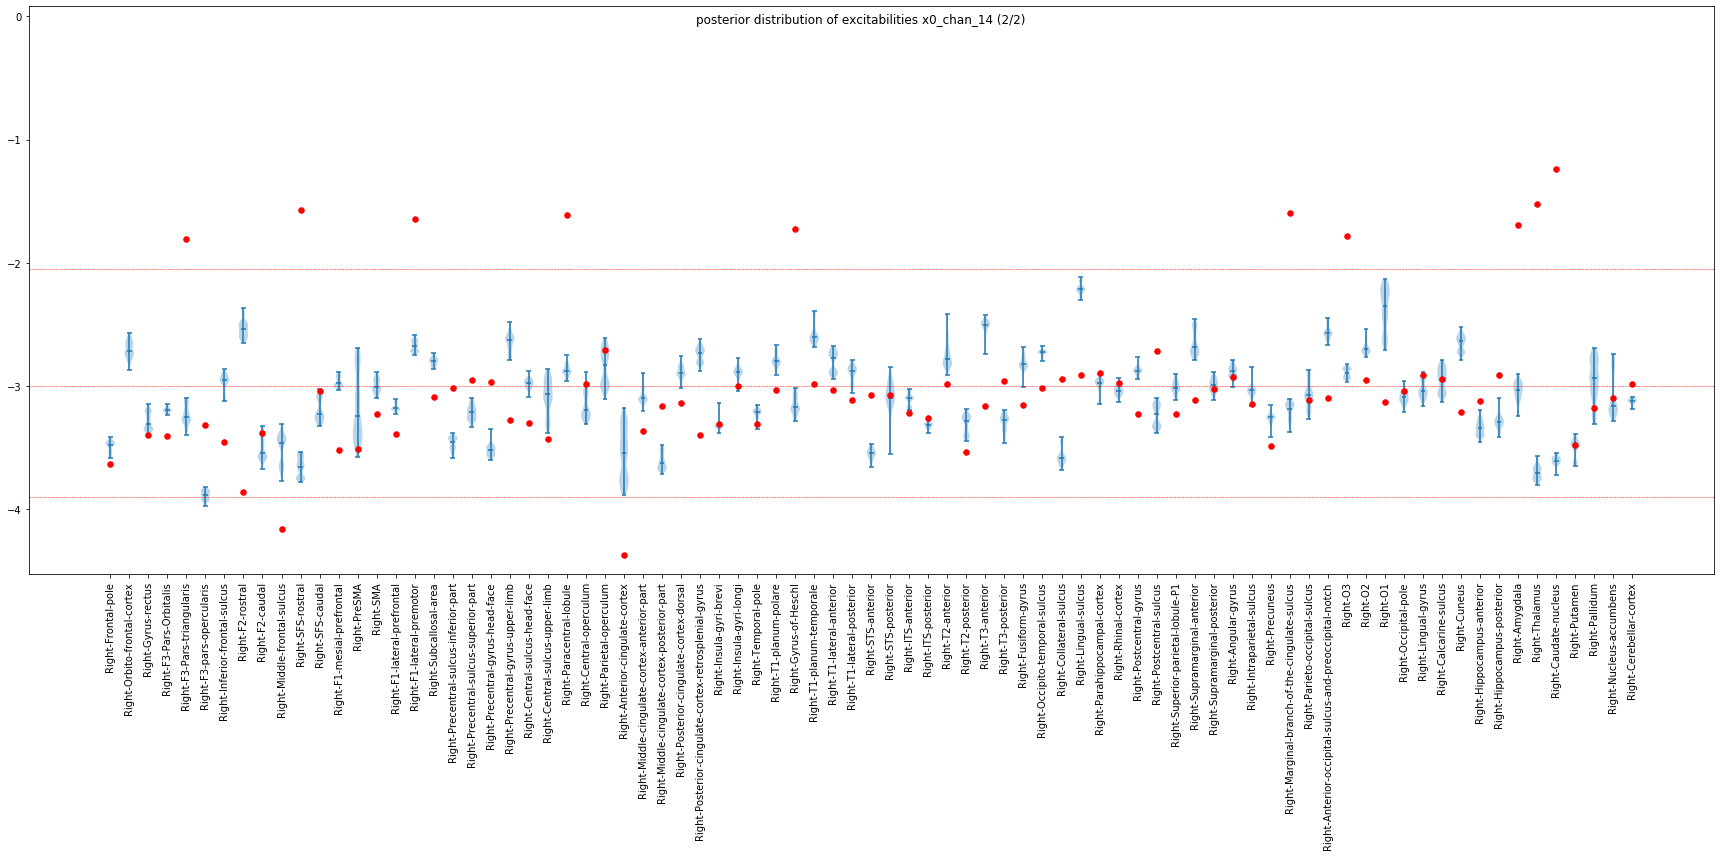

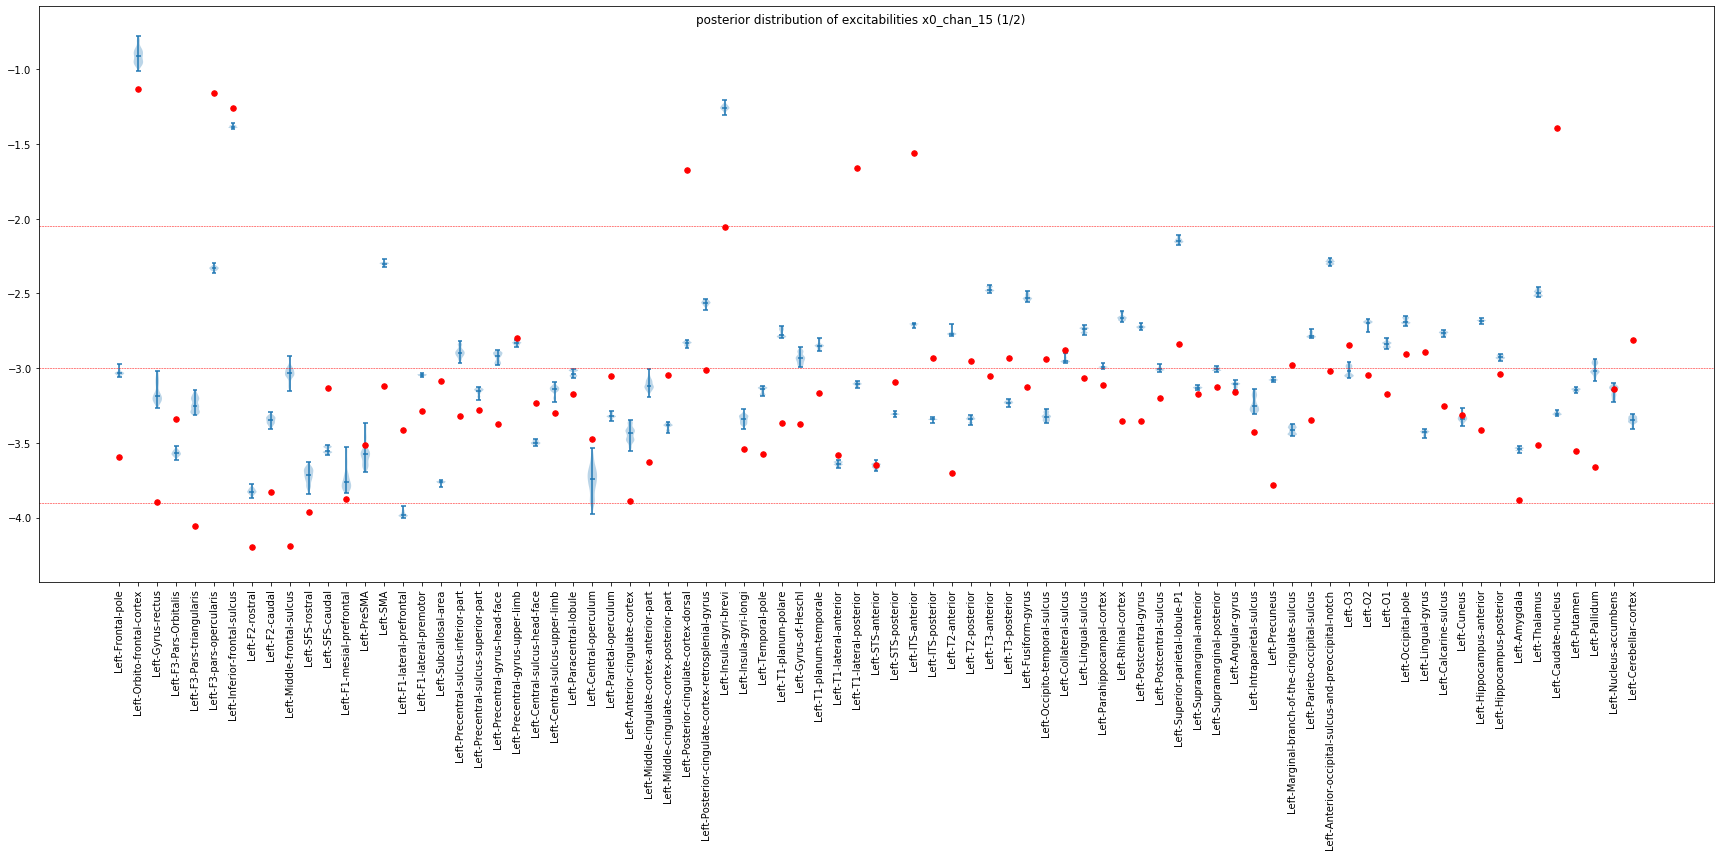

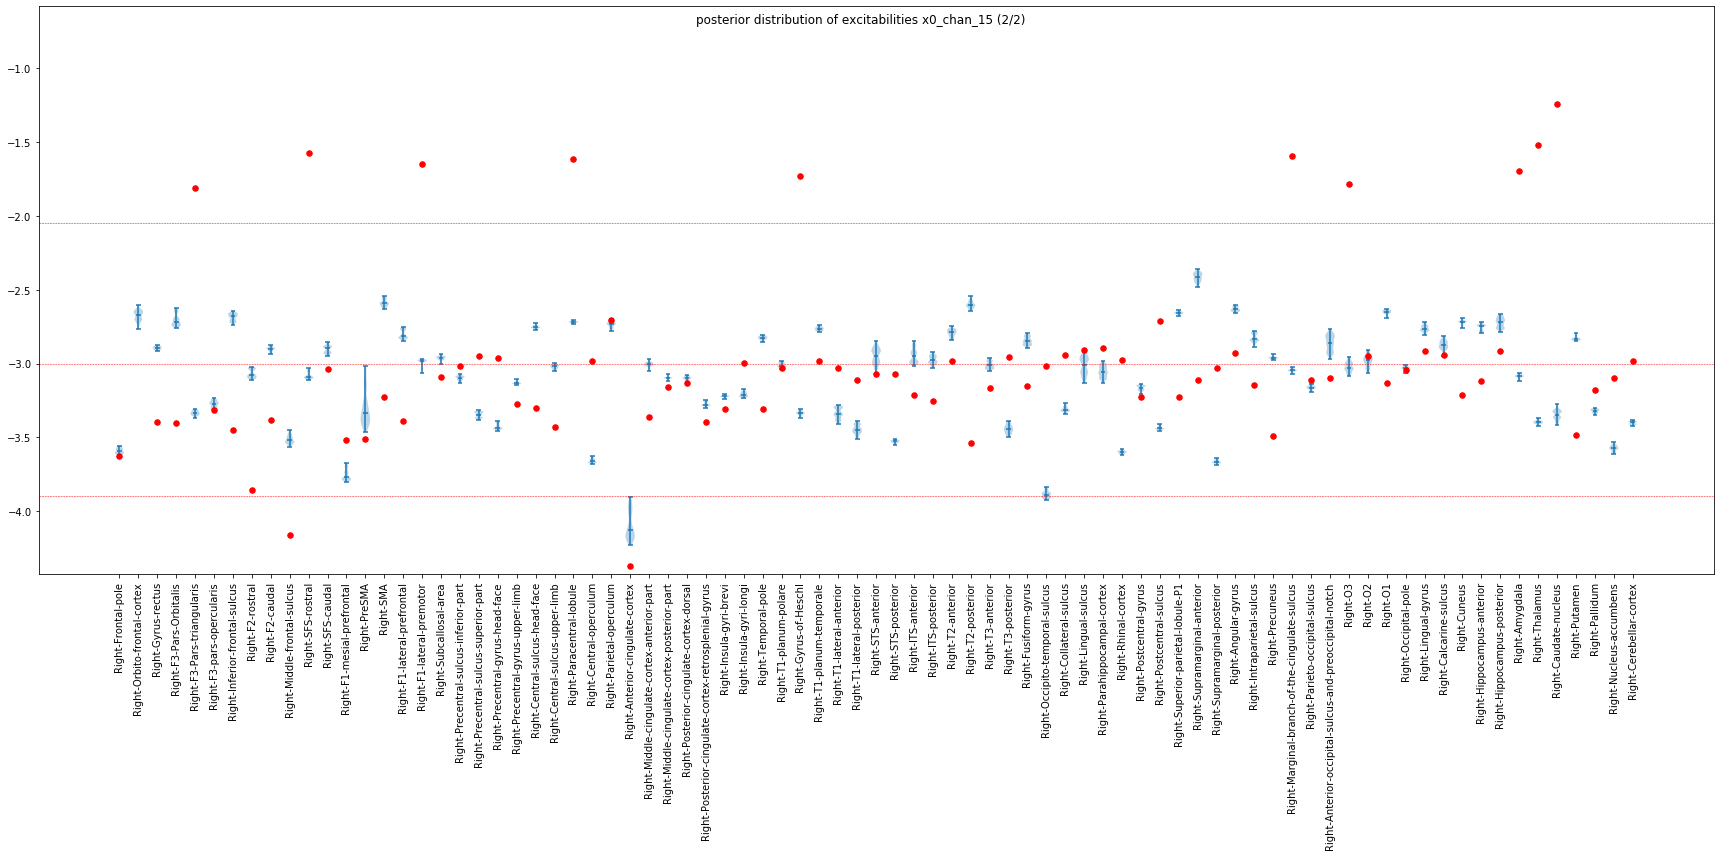

In [68]:
'''
hpf=10
lpf=1
chan = np.arange(16)
for ichan  in chan:
    ichain_fname = f'{sample_output_dir}/csv/samples_{ichan}.npz'

    ichain_results = np.load(ichain_fname)

    samples = np.load(ichain_fname, allow_pickle=True)['arr_0'][()]



    x0sam = samples['x0']

    roi = vep_prepare_op.read_vep_mrtrix_lut()

    ijob = n_best_indices[int(ichan/2)]
    csv_fname = f'{output_dir}/csv/{datafeatures_id}__j{ijob}.csv'
    optimal_results = stan.read_samples([csv_fname])

    MAP_results = np.squeeze(optimal_results['x0'])


    #MAP_rload = f'/data/cluster-vep-backup/RetrospectivePatients/1-Processed/id039_mra/mcmc/fit_V1/optimize/MR_C4P_170124b-cex_0028_hpf10_lpf0.04/csv/init/MR_C4P_170124b-cex_0028_hpf10_lpf0.04__j{ijob}_init.R' 

    #MAP_data = stan.rload(MAP_rload)
    #MAP_results = MAP_data['x0_star']

    fig_dir = op.join(csv_dir, 'figures')


    x0sam_min, x0sam_max = np.min(x0sam)-0.2, np.max(x0sam)+0.2
    figsize = (24, 12)
    for i in range(2):
        fig, ax = plt.subplots(figsize=figsize)

        regions_range = range(i*int(162/2), (i+1)*int(162/2))
        ax.violinplot(x0sam[:, regions_range], positions=range(len(regions_range)), showmedians=True)
        ax.set_ylim([x0sam_min, x0sam_max])
        ax.axhline(y=-3.0, color='r', linestyle='--', lw=0.5)
        ax.axhline(y=-2.05, color='r', linestyle='--', lw=0.5)
        ax.axhline(y=-3.9, color='r', linestyle='--', lw=0.5)
        plt.scatter(range(len(regions_range)), MAP_results[regions_range], marker='o', color='red', s=30, zorder=3)

        ax.set_xticks(range(len(regions_range)))
        ax.set_xticklabels([roi[r] for r in regions_range], rotation='vertical')
        fig.suptitle(f'posterior distribution of excitabilities x0_chan_{ichan} ({i+1}/2)')
        fig.tight_layout()

        fname = op.join(fig_dir, f'posterior_x0_part{i+1}_chan_{ichan}.png')
        print(f'Save {fname}')
        fig.savefig(fname)
'''